# Graphlet Correlation Analysis

Remember, in notebook *Thresholding*, I thresholded contact maps and saved so that
orca can read them.

In this notebook, I perform two actions:
1. I apply `count5` procedure in orca to extract 73 orbits for each loci in each
chromosome. After this stage, graphlets will be save with `.graphlets` extension 
in the `./data` folder.

2. I then read the graphlets and find both loci-wise distance
and graphlet-wise correlations
between the four cell lines.

By repeating steps 1 and 2 for all 23 chromosomes, I will have pairwise MIC values for all
orbits of all cell lines. I would eventually be able to have a data array of shape
``` A(23 * 73) ```, for each pair of cell lines where `A[i, j]` denotes the correlation
between the jth orbit in the ith chromosome. 


In [1]:
import numpy as np
from utility import *
import matplotlib.pyplot as plt
import os
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/bzr0014/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['colors', 'log']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
chr2count = {}
count2chr = {}
count = 0
for chr1 in range(1, 24):
    for chr2 in range(chr1, 24):
        chr2count[(chr1, chr2)] = count
        count2chr[count] = (chr1, chr2)
        count += 1
sameIndices = []
for chr1 in range(1, 24):
    sameIndices.append(chr2count[(chr1, chr1)])
print("Same indices: %s\n"%sameIndices)
differentIndices = []
for chr1 in range(1, 24):
    for chr2 in range(chr1+1, 24):
        differentIndices.append(chr2count[(chr1, chr2)])
print("Different indices: %s"%differentIndices)
indices = np.array([ 0,  1,  2,  4,  5,  6,  7,  8, 15, 16, 17, 18, 19, 20, 21, 22, 23,
        35, 36, 37, 38, 49, 50]) 

Same indices: [0, 23, 45, 66, 86, 105, 123, 140, 156, 171, 185, 198, 210, 221, 231, 240, 248, 255, 261, 266, 270, 273, 275]

Different indices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203,

In [8]:
data_names = ["MIT", "ALL", "RL", "call4"]
root = "./"
file_dir_template = "../data/extracted_all_contact_%s"
file_name_template = "%s/all_in_one_500kb.npy"%(file_dir_template)
print("File Directory: \"%s\""%file_dir_template)
print("File Name Template: \"%s\""%file_name_template)

File Directory: "../data/extracted_all_contact_%s"
File Name Template: "../data/extracted_all_contact_%s/all_in_one_500kb.npy"


# 1. Orbit Extraction:
Once the thresholded contact maps are obtained, graphlets
and orbits can be extracted. We used the orca package in
R programming language to extract the graphlets. As a result
of graphlet extraction, For each loci in each contact map,
a signature vector of size 73 is created. Thus for each cell
line, we would have 276 signature matrices of size $|V_{ij}|\times73$,
where $|V_{ij}|$ is the number of loci involved in contact map
between chromosomes i and j
For a particular $C_{ij}$ , we denote $S_{ij}$ as its signature matrix.
Each cell $S_{ijlo}$ in $S_{ij}$ captures how many times loci $l$ in $C_{ij}$
occured as part of orbit $o$.

The following image illustrates the process of orbit extraction:

<img src='papers/manuscripts/figures/graphlet_extraction.png' width="800">

This process of graphlet extraction is repeated for all four cell 
lines that we have (MIT, ALL, RL and CALL4).

The following R-script reads edge files (`.edges`) corresponding to a chromosome under
 ```data/``` directory. It then writes the resulting orbits into
```data/*.graphlets```.

In [3]:
data_names = ["MIT", "ALL", "RL", "call4"]
root = "../data/"
file_dir_template = "../data/extracted_all_contact_%s"
file_name_template = "%s/all_in_one_500kb.npy"%(file_dir_template)
print("File Directory: \"%s\""%file_dir_template)
print("File Name Template: \"%s\""%file_name_template)

File Directory: "../data/extracted_all_contact_%s"
File Name Template: "../data/extracted_all_contact_%s/all_in_one_500kb.npy"


## Extracting orbits from thresholded files

In [4]:
#for chr1 in range(1, 24):
#    for chr2 in range(chr1, 24):
#        os.system('Rscript rscript_intra.r %s %s'%(chr1, chr2))

## Reading Already saved orbits

In [5]:
graphlets = {}
for cell in data_names:
    graphlets[cell] = {}
    count = 0
    for chr1 in range(1, 24):
        graphlets[cell][chr1] = {}
        for chr2 in range(chr1, 24):
            graphlets[cell][chr1][chr2] = readMat\
            ("%s/data/chr%02d_chr%02d_%s.graphlets"%(root, chr1, chr2, cell.lower()), delimiter=" ").astype('uint32') 
            count += 1

## Putting extracted graphlets in order
The following code block assembles all 23 orbit signature vectors of a loci into a $23 \times 73$ matrix.

In [6]:
lengths = {}
for key in data_names:
    print(key)
    lengths[key] = np.load("%s/lengths_500kb.npy"%(file_dir_template%key))            

num_loci = 100000
loci_data = {}
for cell1 in data_names:
    loci_data[cell1] = {}
    num_loci = int(np.min([np.sum(lengths[cell1][-1]), num_loci]))
    print num_loci
    for l in range(num_loci+1):
        loci_data[cell1][l] = np.zeros((24, 73), dtype='uint32')

for cell1 in data_names:
    for chr1 in range(1, 24):
        for chr2 in range(chr1, 24):
            l1 = lengths[cell1][chr1, :]
            l2 = lengths[cell1][chr2, :]
            temp = graphlets[cell1][chr1][chr2]
            if chr1 == chr2:
                for l in range(len(temp)):
                    loci_abs_num = l1[0] + l
                    loci_data[cell1][loci_abs_num][chr1] = temp[l]                
            else:
                for l in range(l1[1]):
                    loci_abs_num = l1[0] + l
                    loci_data[cell1][loci_abs_num][chr2] = temp[l]                
                for l in range(l1[1], len(temp)):
                    loci_abs_num = l2[0] + l - l1[1]
                    loci_data[cell1][loci_abs_num][chr1] = temp[l]                
                

MIT
ALL
RL
call4
6053
6053
6053
6053


In [10]:
# Test of the above procedure, the absolute difference should be 0
sum_diffs = 0
for cell_index in np.random.randint(0, len(data_names), size=3):
    cell = data_names[cell_index]
    for chr1 in np.random.choice(range(1, 24), size=3):
        for chr2 in np.random.choice(range(1, 24), size=3):
            i = np.argmin([chr1, chr2])
            if i == 1:
                c1 = chr2
                c2 = chr1
            else:
                c1 = chr1
                c2 = chr2
            for loci in np.random.choice(range(lengths[cell][c1, 1]), size=3):
                sum_diffs += int(np.sum(np.abs(loci_data[cell][loci + lengths[cell][c1, 0]][c2] - graphlets[cell][c1][c2][loci])))
print("Absolute Diference: %d"%(sum_diffs))
print len(loci_data['MIT'])

Absolute Diference: 0
6054


In [22]:
## Saving files
#for cell in data_names:
#    for loci in range(num_loci):
#            file_name = "data/%s_loci%d"%(cell, loci)
#            print(file_name)
#            np.save(file_name, loci_data[cell][loci])

data/MIT_loci0
data/MIT_loci1
data/MIT_loci2
data/MIT_loci3
data/MIT_loci4
data/MIT_loci5
data/MIT_loci6
data/MIT_loci7
data/MIT_loci8
data/MIT_loci9
data/MIT_loci10
data/MIT_loci11
data/MIT_loci12
data/MIT_loci13
data/MIT_loci14
data/MIT_loci15
data/MIT_loci16
data/MIT_loci17
data/MIT_loci18
data/MIT_loci19
data/MIT_loci20
data/MIT_loci21
data/MIT_loci22
data/MIT_loci23
data/MIT_loci24
data/MIT_loci25
data/MIT_loci26
data/MIT_loci27
data/MIT_loci28
data/MIT_loci29
data/MIT_loci30
data/MIT_loci31
data/MIT_loci32
data/MIT_loci33
data/MIT_loci34
data/MIT_loci35
data/MIT_loci36
data/MIT_loci37
data/MIT_loci38
data/MIT_loci39
data/MIT_loci40
data/MIT_loci41
data/MIT_loci42
data/MIT_loci43
data/MIT_loci44
data/MIT_loci45
data/MIT_loci46
data/MIT_loci47
data/MIT_loci48
data/MIT_loci49
data/MIT_loci50
data/MIT_loci51
data/MIT_loci52
data/MIT_loci53
data/MIT_loci54
data/MIT_loci55
data/MIT_loci56
data/MIT_loci57
data/MIT_loci58
data/MIT_loci59
data/MIT_loci60
data/MIT_loci61
data/MIT_loci62
da

data/MIT_loci510
data/MIT_loci511
data/MIT_loci512
data/MIT_loci513
data/MIT_loci514
data/MIT_loci515
data/MIT_loci516
data/MIT_loci517
data/MIT_loci518
data/MIT_loci519
data/MIT_loci520
data/MIT_loci521
data/MIT_loci522
data/MIT_loci523
data/MIT_loci524
data/MIT_loci525
data/MIT_loci526
data/MIT_loci527
data/MIT_loci528
data/MIT_loci529
data/MIT_loci530
data/MIT_loci531
data/MIT_loci532
data/MIT_loci533
data/MIT_loci534
data/MIT_loci535
data/MIT_loci536
data/MIT_loci537
data/MIT_loci538
data/MIT_loci539
data/MIT_loci540
data/MIT_loci541
data/MIT_loci542
data/MIT_loci543
data/MIT_loci544
data/MIT_loci545
data/MIT_loci546
data/MIT_loci547
data/MIT_loci548
data/MIT_loci549
data/MIT_loci550
data/MIT_loci551
data/MIT_loci552
data/MIT_loci553
data/MIT_loci554
data/MIT_loci555
data/MIT_loci556
data/MIT_loci557
data/MIT_loci558
data/MIT_loci559
data/MIT_loci560
data/MIT_loci561
data/MIT_loci562
data/MIT_loci563
data/MIT_loci564
data/MIT_loci565
data/MIT_loci566
data/MIT_loci567
data/MIT_loci5

data/MIT_loci1039
data/MIT_loci1040
data/MIT_loci1041
data/MIT_loci1042
data/MIT_loci1043
data/MIT_loci1044
data/MIT_loci1045
data/MIT_loci1046
data/MIT_loci1047
data/MIT_loci1048
data/MIT_loci1049
data/MIT_loci1050
data/MIT_loci1051
data/MIT_loci1052
data/MIT_loci1053
data/MIT_loci1054
data/MIT_loci1055
data/MIT_loci1056
data/MIT_loci1057
data/MIT_loci1058
data/MIT_loci1059
data/MIT_loci1060
data/MIT_loci1061
data/MIT_loci1062
data/MIT_loci1063
data/MIT_loci1064
data/MIT_loci1065
data/MIT_loci1066
data/MIT_loci1067
data/MIT_loci1068
data/MIT_loci1069
data/MIT_loci1070
data/MIT_loci1071
data/MIT_loci1072
data/MIT_loci1073
data/MIT_loci1074
data/MIT_loci1075
data/MIT_loci1076
data/MIT_loci1077
data/MIT_loci1078
data/MIT_loci1079
data/MIT_loci1080
data/MIT_loci1081
data/MIT_loci1082
data/MIT_loci1083
data/MIT_loci1084
data/MIT_loci1085
data/MIT_loci1086
data/MIT_loci1087
data/MIT_loci1088
data/MIT_loci1089
data/MIT_loci1090
data/MIT_loci1091
data/MIT_loci1092
data/MIT_loci1093
data/MIT_l

data/MIT_loci1526
data/MIT_loci1527
data/MIT_loci1528
data/MIT_loci1529
data/MIT_loci1530
data/MIT_loci1531
data/MIT_loci1532
data/MIT_loci1533
data/MIT_loci1534
data/MIT_loci1535
data/MIT_loci1536
data/MIT_loci1537
data/MIT_loci1538
data/MIT_loci1539
data/MIT_loci1540
data/MIT_loci1541
data/MIT_loci1542
data/MIT_loci1543
data/MIT_loci1544
data/MIT_loci1545
data/MIT_loci1546
data/MIT_loci1547
data/MIT_loci1548
data/MIT_loci1549
data/MIT_loci1550
data/MIT_loci1551
data/MIT_loci1552
data/MIT_loci1553
data/MIT_loci1554
data/MIT_loci1555
data/MIT_loci1556
data/MIT_loci1557
data/MIT_loci1558
data/MIT_loci1559
data/MIT_loci1560
data/MIT_loci1561
data/MIT_loci1562
data/MIT_loci1563
data/MIT_loci1564
data/MIT_loci1565
data/MIT_loci1566
data/MIT_loci1567
data/MIT_loci1568
data/MIT_loci1569
data/MIT_loci1570
data/MIT_loci1571
data/MIT_loci1572
data/MIT_loci1573
data/MIT_loci1574
data/MIT_loci1575
data/MIT_loci1576
data/MIT_loci1577
data/MIT_loci1578
data/MIT_loci1579
data/MIT_loci1580
data/MIT_l

data/MIT_loci2031
data/MIT_loci2032
data/MIT_loci2033
data/MIT_loci2034
data/MIT_loci2035
data/MIT_loci2036
data/MIT_loci2037
data/MIT_loci2038
data/MIT_loci2039
data/MIT_loci2040
data/MIT_loci2041
data/MIT_loci2042
data/MIT_loci2043
data/MIT_loci2044
data/MIT_loci2045
data/MIT_loci2046
data/MIT_loci2047
data/MIT_loci2048
data/MIT_loci2049
data/MIT_loci2050
data/MIT_loci2051
data/MIT_loci2052
data/MIT_loci2053
data/MIT_loci2054
data/MIT_loci2055
data/MIT_loci2056
data/MIT_loci2057
data/MIT_loci2058
data/MIT_loci2059
data/MIT_loci2060
data/MIT_loci2061
data/MIT_loci2062
data/MIT_loci2063
data/MIT_loci2064
data/MIT_loci2065
data/MIT_loci2066
data/MIT_loci2067
data/MIT_loci2068
data/MIT_loci2069
data/MIT_loci2070
data/MIT_loci2071
data/MIT_loci2072
data/MIT_loci2073
data/MIT_loci2074
data/MIT_loci2075
data/MIT_loci2076
data/MIT_loci2077
data/MIT_loci2078
data/MIT_loci2079
data/MIT_loci2080
data/MIT_loci2081
data/MIT_loci2082
data/MIT_loci2083
data/MIT_loci2084
data/MIT_loci2085
data/MIT_l

data/MIT_loci2488
data/MIT_loci2489
data/MIT_loci2490
data/MIT_loci2491
data/MIT_loci2492
data/MIT_loci2493
data/MIT_loci2494
data/MIT_loci2495
data/MIT_loci2496
data/MIT_loci2497
data/MIT_loci2498
data/MIT_loci2499
data/MIT_loci2500
data/MIT_loci2501
data/MIT_loci2502
data/MIT_loci2503
data/MIT_loci2504
data/MIT_loci2505
data/MIT_loci2506
data/MIT_loci2507
data/MIT_loci2508
data/MIT_loci2509
data/MIT_loci2510
data/MIT_loci2511
data/MIT_loci2512
data/MIT_loci2513
data/MIT_loci2514
data/MIT_loci2515
data/MIT_loci2516
data/MIT_loci2517
data/MIT_loci2518
data/MIT_loci2519
data/MIT_loci2520
data/MIT_loci2521
data/MIT_loci2522
data/MIT_loci2523
data/MIT_loci2524
data/MIT_loci2525
data/MIT_loci2526
data/MIT_loci2527
data/MIT_loci2528
data/MIT_loci2529
data/MIT_loci2530
data/MIT_loci2531
data/MIT_loci2532
data/MIT_loci2533
data/MIT_loci2534
data/MIT_loci2535
data/MIT_loci2536
data/MIT_loci2537
data/MIT_loci2538
data/MIT_loci2539
data/MIT_loci2540
data/MIT_loci2541
data/MIT_loci2542
data/MIT_l

data/MIT_loci2947
data/MIT_loci2948
data/MIT_loci2949
data/MIT_loci2950
data/MIT_loci2951
data/MIT_loci2952
data/MIT_loci2953
data/MIT_loci2954
data/MIT_loci2955
data/MIT_loci2956
data/MIT_loci2957
data/MIT_loci2958
data/MIT_loci2959
data/MIT_loci2960
data/MIT_loci2961
data/MIT_loci2962
data/MIT_loci2963
data/MIT_loci2964
data/MIT_loci2965
data/MIT_loci2966
data/MIT_loci2967
data/MIT_loci2968
data/MIT_loci2969
data/MIT_loci2970
data/MIT_loci2971
data/MIT_loci2972
data/MIT_loci2973
data/MIT_loci2974
data/MIT_loci2975
data/MIT_loci2976
data/MIT_loci2977
data/MIT_loci2978
data/MIT_loci2979
data/MIT_loci2980
data/MIT_loci2981
data/MIT_loci2982
data/MIT_loci2983
data/MIT_loci2984
data/MIT_loci2985
data/MIT_loci2986
data/MIT_loci2987
data/MIT_loci2988
data/MIT_loci2989
data/MIT_loci2990
data/MIT_loci2991
data/MIT_loci2992
data/MIT_loci2993
data/MIT_loci2994
data/MIT_loci2995
data/MIT_loci2996
data/MIT_loci2997
data/MIT_loci2998
data/MIT_loci2999
data/MIT_loci3000
data/MIT_loci3001
data/MIT_l

data/MIT_loci3443
data/MIT_loci3444
data/MIT_loci3445
data/MIT_loci3446
data/MIT_loci3447
data/MIT_loci3448
data/MIT_loci3449
data/MIT_loci3450
data/MIT_loci3451
data/MIT_loci3452
data/MIT_loci3453
data/MIT_loci3454
data/MIT_loci3455
data/MIT_loci3456
data/MIT_loci3457
data/MIT_loci3458
data/MIT_loci3459
data/MIT_loci3460
data/MIT_loci3461
data/MIT_loci3462
data/MIT_loci3463
data/MIT_loci3464
data/MIT_loci3465
data/MIT_loci3466
data/MIT_loci3467
data/MIT_loci3468
data/MIT_loci3469
data/MIT_loci3470
data/MIT_loci3471
data/MIT_loci3472
data/MIT_loci3473
data/MIT_loci3474
data/MIT_loci3475
data/MIT_loci3476
data/MIT_loci3477
data/MIT_loci3478
data/MIT_loci3479
data/MIT_loci3480
data/MIT_loci3481
data/MIT_loci3482
data/MIT_loci3483
data/MIT_loci3484
data/MIT_loci3485
data/MIT_loci3486
data/MIT_loci3487
data/MIT_loci3488
data/MIT_loci3489
data/MIT_loci3490
data/MIT_loci3491
data/MIT_loci3492
data/MIT_loci3493
data/MIT_loci3494
data/MIT_loci3495
data/MIT_loci3496
data/MIT_loci3497
data/MIT_l

data/MIT_loci3941
data/MIT_loci3942
data/MIT_loci3943
data/MIT_loci3944
data/MIT_loci3945
data/MIT_loci3946
data/MIT_loci3947
data/MIT_loci3948
data/MIT_loci3949
data/MIT_loci3950
data/MIT_loci3951
data/MIT_loci3952
data/MIT_loci3953
data/MIT_loci3954
data/MIT_loci3955
data/MIT_loci3956
data/MIT_loci3957
data/MIT_loci3958
data/MIT_loci3959
data/MIT_loci3960
data/MIT_loci3961
data/MIT_loci3962
data/MIT_loci3963
data/MIT_loci3964
data/MIT_loci3965
data/MIT_loci3966
data/MIT_loci3967
data/MIT_loci3968
data/MIT_loci3969
data/MIT_loci3970
data/MIT_loci3971
data/MIT_loci3972
data/MIT_loci3973
data/MIT_loci3974
data/MIT_loci3975
data/MIT_loci3976
data/MIT_loci3977
data/MIT_loci3978
data/MIT_loci3979
data/MIT_loci3980
data/MIT_loci3981
data/MIT_loci3982
data/MIT_loci3983
data/MIT_loci3984
data/MIT_loci3985
data/MIT_loci3986
data/MIT_loci3987
data/MIT_loci3988
data/MIT_loci3989
data/MIT_loci3990
data/MIT_loci3991
data/MIT_loci3992
data/MIT_loci3993
data/MIT_loci3994
data/MIT_loci3995
data/MIT_l

data/MIT_loci4444
data/MIT_loci4445
data/MIT_loci4446
data/MIT_loci4447
data/MIT_loci4448
data/MIT_loci4449
data/MIT_loci4450
data/MIT_loci4451
data/MIT_loci4452
data/MIT_loci4453
data/MIT_loci4454
data/MIT_loci4455
data/MIT_loci4456
data/MIT_loci4457
data/MIT_loci4458
data/MIT_loci4459
data/MIT_loci4460
data/MIT_loci4461
data/MIT_loci4462
data/MIT_loci4463
data/MIT_loci4464
data/MIT_loci4465
data/MIT_loci4466
data/MIT_loci4467
data/MIT_loci4468
data/MIT_loci4469
data/MIT_loci4470
data/MIT_loci4471
data/MIT_loci4472
data/MIT_loci4473
data/MIT_loci4474
data/MIT_loci4475
data/MIT_loci4476
data/MIT_loci4477
data/MIT_loci4478
data/MIT_loci4479
data/MIT_loci4480
data/MIT_loci4481
data/MIT_loci4482
data/MIT_loci4483
data/MIT_loci4484
data/MIT_loci4485
data/MIT_loci4486
data/MIT_loci4487
data/MIT_loci4488
data/MIT_loci4489
data/MIT_loci4490
data/MIT_loci4491
data/MIT_loci4492
data/MIT_loci4493
data/MIT_loci4494
data/MIT_loci4495
data/MIT_loci4496
data/MIT_loci4497
data/MIT_loci4498
data/MIT_l

data/MIT_loci4933
data/MIT_loci4934
data/MIT_loci4935
data/MIT_loci4936
data/MIT_loci4937
data/MIT_loci4938
data/MIT_loci4939
data/MIT_loci4940
data/MIT_loci4941
data/MIT_loci4942
data/MIT_loci4943
data/MIT_loci4944
data/MIT_loci4945
data/MIT_loci4946
data/MIT_loci4947
data/MIT_loci4948
data/MIT_loci4949
data/MIT_loci4950
data/MIT_loci4951
data/MIT_loci4952
data/MIT_loci4953
data/MIT_loci4954
data/MIT_loci4955
data/MIT_loci4956
data/MIT_loci4957
data/MIT_loci4958
data/MIT_loci4959
data/MIT_loci4960
data/MIT_loci4961
data/MIT_loci4962
data/MIT_loci4963
data/MIT_loci4964
data/MIT_loci4965
data/MIT_loci4966
data/MIT_loci4967
data/MIT_loci4968
data/MIT_loci4969
data/MIT_loci4970
data/MIT_loci4971
data/MIT_loci4972
data/MIT_loci4973
data/MIT_loci4974
data/MIT_loci4975
data/MIT_loci4976
data/MIT_loci4977
data/MIT_loci4978
data/MIT_loci4979
data/MIT_loci4980
data/MIT_loci4981
data/MIT_loci4982
data/MIT_loci4983
data/MIT_loci4984
data/MIT_loci4985
data/MIT_loci4986
data/MIT_loci4987
data/MIT_l

data/MIT_loci5437
data/MIT_loci5438
data/MIT_loci5439
data/MIT_loci5440
data/MIT_loci5441
data/MIT_loci5442
data/MIT_loci5443
data/MIT_loci5444
data/MIT_loci5445
data/MIT_loci5446
data/MIT_loci5447
data/MIT_loci5448
data/MIT_loci5449
data/MIT_loci5450
data/MIT_loci5451
data/MIT_loci5452
data/MIT_loci5453
data/MIT_loci5454
data/MIT_loci5455
data/MIT_loci5456
data/MIT_loci5457
data/MIT_loci5458
data/MIT_loci5459
data/MIT_loci5460
data/MIT_loci5461
data/MIT_loci5462
data/MIT_loci5463
data/MIT_loci5464
data/MIT_loci5465
data/MIT_loci5466
data/MIT_loci5467
data/MIT_loci5468
data/MIT_loci5469
data/MIT_loci5470
data/MIT_loci5471
data/MIT_loci5472
data/MIT_loci5473
data/MIT_loci5474
data/MIT_loci5475
data/MIT_loci5476
data/MIT_loci5477
data/MIT_loci5478
data/MIT_loci5479
data/MIT_loci5480
data/MIT_loci5481
data/MIT_loci5482
data/MIT_loci5483
data/MIT_loci5484
data/MIT_loci5485
data/MIT_loci5486
data/MIT_loci5487
data/MIT_loci5488
data/MIT_loci5489
data/MIT_loci5490
data/MIT_loci5491
data/MIT_l

data/MIT_loci5934
data/MIT_loci5935
data/MIT_loci5936
data/MIT_loci5937
data/MIT_loci5938
data/MIT_loci5939
data/MIT_loci5940
data/MIT_loci5941
data/MIT_loci5942
data/MIT_loci5943
data/MIT_loci5944
data/MIT_loci5945
data/MIT_loci5946
data/MIT_loci5947
data/MIT_loci5948
data/MIT_loci5949
data/MIT_loci5950
data/MIT_loci5951
data/MIT_loci5952
data/MIT_loci5953
data/MIT_loci5954
data/MIT_loci5955
data/MIT_loci5956
data/MIT_loci5957
data/MIT_loci5958
data/MIT_loci5959
data/MIT_loci5960
data/MIT_loci5961
data/MIT_loci5962
data/MIT_loci5963
data/MIT_loci5964
data/MIT_loci5965
data/MIT_loci5966
data/MIT_loci5967
data/MIT_loci5968
data/MIT_loci5969
data/MIT_loci5970
data/MIT_loci5971
data/MIT_loci5972
data/MIT_loci5973
data/MIT_loci5974
data/MIT_loci5975
data/MIT_loci5976
data/MIT_loci5977
data/MIT_loci5978
data/MIT_loci5979
data/MIT_loci5980
data/MIT_loci5981
data/MIT_loci5982
data/MIT_loci5983
data/MIT_loci5984
data/MIT_loci5985
data/MIT_loci5986
data/MIT_loci5987
data/MIT_loci5988
data/MIT_l

data/ALL_loci380
data/ALL_loci381
data/ALL_loci382
data/ALL_loci383
data/ALL_loci384
data/ALL_loci385
data/ALL_loci386
data/ALL_loci387
data/ALL_loci388
data/ALL_loci389
data/ALL_loci390
data/ALL_loci391
data/ALL_loci392
data/ALL_loci393
data/ALL_loci394
data/ALL_loci395
data/ALL_loci396
data/ALL_loci397
data/ALL_loci398
data/ALL_loci399
data/ALL_loci400
data/ALL_loci401
data/ALL_loci402
data/ALL_loci403
data/ALL_loci404
data/ALL_loci405
data/ALL_loci406
data/ALL_loci407
data/ALL_loci408
data/ALL_loci409
data/ALL_loci410
data/ALL_loci411
data/ALL_loci412
data/ALL_loci413
data/ALL_loci414
data/ALL_loci415
data/ALL_loci416
data/ALL_loci417
data/ALL_loci418
data/ALL_loci419
data/ALL_loci420
data/ALL_loci421
data/ALL_loci422
data/ALL_loci423
data/ALL_loci424
data/ALL_loci425
data/ALL_loci426
data/ALL_loci427
data/ALL_loci428
data/ALL_loci429
data/ALL_loci430
data/ALL_loci431
data/ALL_loci432
data/ALL_loci433
data/ALL_loci434
data/ALL_loci435
data/ALL_loci436
data/ALL_loci437
data/ALL_loci4

data/ALL_loci885
data/ALL_loci886
data/ALL_loci887
data/ALL_loci888
data/ALL_loci889
data/ALL_loci890
data/ALL_loci891
data/ALL_loci892
data/ALL_loci893
data/ALL_loci894
data/ALL_loci895
data/ALL_loci896
data/ALL_loci897
data/ALL_loci898
data/ALL_loci899
data/ALL_loci900
data/ALL_loci901
data/ALL_loci902
data/ALL_loci903
data/ALL_loci904
data/ALL_loci905
data/ALL_loci906
data/ALL_loci907
data/ALL_loci908
data/ALL_loci909
data/ALL_loci910
data/ALL_loci911
data/ALL_loci912
data/ALL_loci913
data/ALL_loci914
data/ALL_loci915
data/ALL_loci916
data/ALL_loci917
data/ALL_loci918
data/ALL_loci919
data/ALL_loci920
data/ALL_loci921
data/ALL_loci922
data/ALL_loci923
data/ALL_loci924
data/ALL_loci925
data/ALL_loci926
data/ALL_loci927
data/ALL_loci928
data/ALL_loci929
data/ALL_loci930
data/ALL_loci931
data/ALL_loci932
data/ALL_loci933
data/ALL_loci934
data/ALL_loci935
data/ALL_loci936
data/ALL_loci937
data/ALL_loci938
data/ALL_loci939
data/ALL_loci940
data/ALL_loci941
data/ALL_loci942
data/ALL_loci9

data/ALL_loci1370
data/ALL_loci1371
data/ALL_loci1372
data/ALL_loci1373
data/ALL_loci1374
data/ALL_loci1375
data/ALL_loci1376
data/ALL_loci1377
data/ALL_loci1378
data/ALL_loci1379
data/ALL_loci1380
data/ALL_loci1381
data/ALL_loci1382
data/ALL_loci1383
data/ALL_loci1384
data/ALL_loci1385
data/ALL_loci1386
data/ALL_loci1387
data/ALL_loci1388
data/ALL_loci1389
data/ALL_loci1390
data/ALL_loci1391
data/ALL_loci1392
data/ALL_loci1393
data/ALL_loci1394
data/ALL_loci1395
data/ALL_loci1396
data/ALL_loci1397
data/ALL_loci1398
data/ALL_loci1399
data/ALL_loci1400
data/ALL_loci1401
data/ALL_loci1402
data/ALL_loci1403
data/ALL_loci1404
data/ALL_loci1405
data/ALL_loci1406
data/ALL_loci1407
data/ALL_loci1408
data/ALL_loci1409
data/ALL_loci1410
data/ALL_loci1411
data/ALL_loci1412
data/ALL_loci1413
data/ALL_loci1414
data/ALL_loci1415
data/ALL_loci1416
data/ALL_loci1417
data/ALL_loci1418
data/ALL_loci1419
data/ALL_loci1420
data/ALL_loci1421
data/ALL_loci1422
data/ALL_loci1423
data/ALL_loci1424
data/ALL_l

data/ALL_loci1872
data/ALL_loci1873
data/ALL_loci1874
data/ALL_loci1875
data/ALL_loci1876
data/ALL_loci1877
data/ALL_loci1878
data/ALL_loci1879
data/ALL_loci1880
data/ALL_loci1881
data/ALL_loci1882
data/ALL_loci1883
data/ALL_loci1884
data/ALL_loci1885
data/ALL_loci1886
data/ALL_loci1887
data/ALL_loci1888
data/ALL_loci1889
data/ALL_loci1890
data/ALL_loci1891
data/ALL_loci1892
data/ALL_loci1893
data/ALL_loci1894
data/ALL_loci1895
data/ALL_loci1896
data/ALL_loci1897
data/ALL_loci1898
data/ALL_loci1899
data/ALL_loci1900
data/ALL_loci1901
data/ALL_loci1902
data/ALL_loci1903
data/ALL_loci1904
data/ALL_loci1905
data/ALL_loci1906
data/ALL_loci1907
data/ALL_loci1908
data/ALL_loci1909
data/ALL_loci1910
data/ALL_loci1911
data/ALL_loci1912
data/ALL_loci1913
data/ALL_loci1914
data/ALL_loci1915
data/ALL_loci1916
data/ALL_loci1917
data/ALL_loci1918
data/ALL_loci1919
data/ALL_loci1920
data/ALL_loci1921
data/ALL_loci1922
data/ALL_loci1923
data/ALL_loci1924
data/ALL_loci1925
data/ALL_loci1926
data/ALL_l

data/ALL_loci2375
data/ALL_loci2376
data/ALL_loci2377
data/ALL_loci2378
data/ALL_loci2379
data/ALL_loci2380
data/ALL_loci2381
data/ALL_loci2382
data/ALL_loci2383
data/ALL_loci2384
data/ALL_loci2385
data/ALL_loci2386
data/ALL_loci2387
data/ALL_loci2388
data/ALL_loci2389
data/ALL_loci2390
data/ALL_loci2391
data/ALL_loci2392
data/ALL_loci2393
data/ALL_loci2394
data/ALL_loci2395
data/ALL_loci2396
data/ALL_loci2397
data/ALL_loci2398
data/ALL_loci2399
data/ALL_loci2400
data/ALL_loci2401
data/ALL_loci2402
data/ALL_loci2403
data/ALL_loci2404
data/ALL_loci2405
data/ALL_loci2406
data/ALL_loci2407
data/ALL_loci2408
data/ALL_loci2409
data/ALL_loci2410
data/ALL_loci2411
data/ALL_loci2412
data/ALL_loci2413
data/ALL_loci2414
data/ALL_loci2415
data/ALL_loci2416
data/ALL_loci2417
data/ALL_loci2418
data/ALL_loci2419
data/ALL_loci2420
data/ALL_loci2421
data/ALL_loci2422
data/ALL_loci2423
data/ALL_loci2424
data/ALL_loci2425
data/ALL_loci2426
data/ALL_loci2427
data/ALL_loci2428
data/ALL_loci2429
data/ALL_l

data/ALL_loci2873
data/ALL_loci2874
data/ALL_loci2875
data/ALL_loci2876
data/ALL_loci2877
data/ALL_loci2878
data/ALL_loci2879
data/ALL_loci2880
data/ALL_loci2881
data/ALL_loci2882
data/ALL_loci2883
data/ALL_loci2884
data/ALL_loci2885
data/ALL_loci2886
data/ALL_loci2887
data/ALL_loci2888
data/ALL_loci2889
data/ALL_loci2890
data/ALL_loci2891
data/ALL_loci2892
data/ALL_loci2893
data/ALL_loci2894
data/ALL_loci2895
data/ALL_loci2896
data/ALL_loci2897
data/ALL_loci2898
data/ALL_loci2899
data/ALL_loci2900
data/ALL_loci2901
data/ALL_loci2902
data/ALL_loci2903
data/ALL_loci2904
data/ALL_loci2905
data/ALL_loci2906
data/ALL_loci2907
data/ALL_loci2908
data/ALL_loci2909
data/ALL_loci2910
data/ALL_loci2911
data/ALL_loci2912
data/ALL_loci2913
data/ALL_loci2914
data/ALL_loci2915
data/ALL_loci2916
data/ALL_loci2917
data/ALL_loci2918
data/ALL_loci2919
data/ALL_loci2920
data/ALL_loci2921
data/ALL_loci2922
data/ALL_loci2923
data/ALL_loci2924
data/ALL_loci2925
data/ALL_loci2926
data/ALL_loci2927
data/ALL_l

data/ALL_loci3373
data/ALL_loci3374
data/ALL_loci3375
data/ALL_loci3376
data/ALL_loci3377
data/ALL_loci3378
data/ALL_loci3379
data/ALL_loci3380
data/ALL_loci3381
data/ALL_loci3382
data/ALL_loci3383
data/ALL_loci3384
data/ALL_loci3385
data/ALL_loci3386
data/ALL_loci3387
data/ALL_loci3388
data/ALL_loci3389
data/ALL_loci3390
data/ALL_loci3391
data/ALL_loci3392
data/ALL_loci3393
data/ALL_loci3394
data/ALL_loci3395
data/ALL_loci3396
data/ALL_loci3397
data/ALL_loci3398
data/ALL_loci3399
data/ALL_loci3400
data/ALL_loci3401
data/ALL_loci3402
data/ALL_loci3403
data/ALL_loci3404
data/ALL_loci3405
data/ALL_loci3406
data/ALL_loci3407
data/ALL_loci3408
data/ALL_loci3409
data/ALL_loci3410
data/ALL_loci3411
data/ALL_loci3412
data/ALL_loci3413
data/ALL_loci3414
data/ALL_loci3415
data/ALL_loci3416
data/ALL_loci3417
data/ALL_loci3418
data/ALL_loci3419
data/ALL_loci3420
data/ALL_loci3421
data/ALL_loci3422
data/ALL_loci3423
data/ALL_loci3424
data/ALL_loci3425
data/ALL_loci3426
data/ALL_loci3427
data/ALL_l

data/ALL_loci3878
data/ALL_loci3879
data/ALL_loci3880
data/ALL_loci3881
data/ALL_loci3882
data/ALL_loci3883
data/ALL_loci3884
data/ALL_loci3885
data/ALL_loci3886
data/ALL_loci3887
data/ALL_loci3888
data/ALL_loci3889
data/ALL_loci3890
data/ALL_loci3891
data/ALL_loci3892
data/ALL_loci3893
data/ALL_loci3894
data/ALL_loci3895
data/ALL_loci3896
data/ALL_loci3897
data/ALL_loci3898
data/ALL_loci3899
data/ALL_loci3900
data/ALL_loci3901
data/ALL_loci3902
data/ALL_loci3903
data/ALL_loci3904
data/ALL_loci3905
data/ALL_loci3906
data/ALL_loci3907
data/ALL_loci3908
data/ALL_loci3909
data/ALL_loci3910
data/ALL_loci3911
data/ALL_loci3912
data/ALL_loci3913
data/ALL_loci3914
data/ALL_loci3915
data/ALL_loci3916
data/ALL_loci3917
data/ALL_loci3918
data/ALL_loci3919
data/ALL_loci3920
data/ALL_loci3921
data/ALL_loci3922
data/ALL_loci3923
data/ALL_loci3924
data/ALL_loci3925
data/ALL_loci3926
data/ALL_loci3927
data/ALL_loci3928
data/ALL_loci3929
data/ALL_loci3930
data/ALL_loci3931
data/ALL_loci3932
data/ALL_l

data/ALL_loci4340
data/ALL_loci4341
data/ALL_loci4342
data/ALL_loci4343
data/ALL_loci4344
data/ALL_loci4345
data/ALL_loci4346
data/ALL_loci4347
data/ALL_loci4348
data/ALL_loci4349
data/ALL_loci4350
data/ALL_loci4351
data/ALL_loci4352
data/ALL_loci4353
data/ALL_loci4354
data/ALL_loci4355
data/ALL_loci4356
data/ALL_loci4357
data/ALL_loci4358
data/ALL_loci4359
data/ALL_loci4360
data/ALL_loci4361
data/ALL_loci4362
data/ALL_loci4363
data/ALL_loci4364
data/ALL_loci4365
data/ALL_loci4366
data/ALL_loci4367
data/ALL_loci4368
data/ALL_loci4369
data/ALL_loci4370
data/ALL_loci4371
data/ALL_loci4372
data/ALL_loci4373
data/ALL_loci4374
data/ALL_loci4375
data/ALL_loci4376
data/ALL_loci4377
data/ALL_loci4378
data/ALL_loci4379
data/ALL_loci4380
data/ALL_loci4381
data/ALL_loci4382
data/ALL_loci4383
data/ALL_loci4384
data/ALL_loci4385
data/ALL_loci4386
data/ALL_loci4387
data/ALL_loci4388
data/ALL_loci4389
data/ALL_loci4390
data/ALL_loci4391
data/ALL_loci4392
data/ALL_loci4393
data/ALL_loci4394
data/ALL_l

data/ALL_loci4809
data/ALL_loci4810
data/ALL_loci4811
data/ALL_loci4812
data/ALL_loci4813
data/ALL_loci4814
data/ALL_loci4815
data/ALL_loci4816
data/ALL_loci4817
data/ALL_loci4818
data/ALL_loci4819
data/ALL_loci4820
data/ALL_loci4821
data/ALL_loci4822
data/ALL_loci4823
data/ALL_loci4824
data/ALL_loci4825
data/ALL_loci4826
data/ALL_loci4827
data/ALL_loci4828
data/ALL_loci4829
data/ALL_loci4830
data/ALL_loci4831
data/ALL_loci4832
data/ALL_loci4833
data/ALL_loci4834
data/ALL_loci4835
data/ALL_loci4836
data/ALL_loci4837
data/ALL_loci4838
data/ALL_loci4839
data/ALL_loci4840
data/ALL_loci4841
data/ALL_loci4842
data/ALL_loci4843
data/ALL_loci4844
data/ALL_loci4845
data/ALL_loci4846
data/ALL_loci4847
data/ALL_loci4848
data/ALL_loci4849
data/ALL_loci4850
data/ALL_loci4851
data/ALL_loci4852
data/ALL_loci4853
data/ALL_loci4854
data/ALL_loci4855
data/ALL_loci4856
data/ALL_loci4857
data/ALL_loci4858
data/ALL_loci4859
data/ALL_loci4860
data/ALL_loci4861
data/ALL_loci4862
data/ALL_loci4863
data/ALL_l

data/ALL_loci5267
data/ALL_loci5268
data/ALL_loci5269
data/ALL_loci5270
data/ALL_loci5271
data/ALL_loci5272
data/ALL_loci5273
data/ALL_loci5274
data/ALL_loci5275
data/ALL_loci5276
data/ALL_loci5277
data/ALL_loci5278
data/ALL_loci5279
data/ALL_loci5280
data/ALL_loci5281
data/ALL_loci5282
data/ALL_loci5283
data/ALL_loci5284
data/ALL_loci5285
data/ALL_loci5286
data/ALL_loci5287
data/ALL_loci5288
data/ALL_loci5289
data/ALL_loci5290
data/ALL_loci5291
data/ALL_loci5292
data/ALL_loci5293
data/ALL_loci5294
data/ALL_loci5295
data/ALL_loci5296
data/ALL_loci5297
data/ALL_loci5298
data/ALL_loci5299
data/ALL_loci5300
data/ALL_loci5301
data/ALL_loci5302
data/ALL_loci5303
data/ALL_loci5304
data/ALL_loci5305
data/ALL_loci5306
data/ALL_loci5307
data/ALL_loci5308
data/ALL_loci5309
data/ALL_loci5310
data/ALL_loci5311
data/ALL_loci5312
data/ALL_loci5313
data/ALL_loci5314
data/ALL_loci5315
data/ALL_loci5316
data/ALL_loci5317
data/ALL_loci5318
data/ALL_loci5319
data/ALL_loci5320
data/ALL_loci5321
data/ALL_l

data/ALL_loci5774
data/ALL_loci5775
data/ALL_loci5776
data/ALL_loci5777
data/ALL_loci5778
data/ALL_loci5779
data/ALL_loci5780
data/ALL_loci5781
data/ALL_loci5782
data/ALL_loci5783
data/ALL_loci5784
data/ALL_loci5785
data/ALL_loci5786
data/ALL_loci5787
data/ALL_loci5788
data/ALL_loci5789
data/ALL_loci5790
data/ALL_loci5791
data/ALL_loci5792
data/ALL_loci5793
data/ALL_loci5794
data/ALL_loci5795
data/ALL_loci5796
data/ALL_loci5797
data/ALL_loci5798
data/ALL_loci5799
data/ALL_loci5800
data/ALL_loci5801
data/ALL_loci5802
data/ALL_loci5803
data/ALL_loci5804
data/ALL_loci5805
data/ALL_loci5806
data/ALL_loci5807
data/ALL_loci5808
data/ALL_loci5809
data/ALL_loci5810
data/ALL_loci5811
data/ALL_loci5812
data/ALL_loci5813
data/ALL_loci5814
data/ALL_loci5815
data/ALL_loci5816
data/ALL_loci5817
data/ALL_loci5818
data/ALL_loci5819
data/ALL_loci5820
data/ALL_loci5821
data/ALL_loci5822
data/ALL_loci5823
data/ALL_loci5824
data/ALL_loci5825
data/ALL_loci5826
data/ALL_loci5827
data/ALL_loci5828
data/ALL_l

data/RL_loci255
data/RL_loci256
data/RL_loci257
data/RL_loci258
data/RL_loci259
data/RL_loci260
data/RL_loci261
data/RL_loci262
data/RL_loci263
data/RL_loci264
data/RL_loci265
data/RL_loci266
data/RL_loci267
data/RL_loci268
data/RL_loci269
data/RL_loci270
data/RL_loci271
data/RL_loci272
data/RL_loci273
data/RL_loci274
data/RL_loci275
data/RL_loci276
data/RL_loci277
data/RL_loci278
data/RL_loci279
data/RL_loci280
data/RL_loci281
data/RL_loci282
data/RL_loci283
data/RL_loci284
data/RL_loci285
data/RL_loci286
data/RL_loci287
data/RL_loci288
data/RL_loci289
data/RL_loci290
data/RL_loci291
data/RL_loci292
data/RL_loci293
data/RL_loci294
data/RL_loci295
data/RL_loci296
data/RL_loci297
data/RL_loci298
data/RL_loci299
data/RL_loci300
data/RL_loci301
data/RL_loci302
data/RL_loci303
data/RL_loci304
data/RL_loci305
data/RL_loci306
data/RL_loci307
data/RL_loci308
data/RL_loci309
data/RL_loci310
data/RL_loci311
data/RL_loci312
data/RL_loci313
data/RL_loci314
data/RL_loci315
data/RL_loci316
data/RL_

data/RL_loci822
data/RL_loci823
data/RL_loci824
data/RL_loci825
data/RL_loci826
data/RL_loci827
data/RL_loci828
data/RL_loci829
data/RL_loci830
data/RL_loci831
data/RL_loci832
data/RL_loci833
data/RL_loci834
data/RL_loci835
data/RL_loci836
data/RL_loci837
data/RL_loci838
data/RL_loci839
data/RL_loci840
data/RL_loci841
data/RL_loci842
data/RL_loci843
data/RL_loci844
data/RL_loci845
data/RL_loci846
data/RL_loci847
data/RL_loci848
data/RL_loci849
data/RL_loci850
data/RL_loci851
data/RL_loci852
data/RL_loci853
data/RL_loci854
data/RL_loci855
data/RL_loci856
data/RL_loci857
data/RL_loci858
data/RL_loci859
data/RL_loci860
data/RL_loci861
data/RL_loci862
data/RL_loci863
data/RL_loci864
data/RL_loci865
data/RL_loci866
data/RL_loci867
data/RL_loci868
data/RL_loci869
data/RL_loci870
data/RL_loci871
data/RL_loci872
data/RL_loci873
data/RL_loci874
data/RL_loci875
data/RL_loci876
data/RL_loci877
data/RL_loci878
data/RL_loci879
data/RL_loci880
data/RL_loci881
data/RL_loci882
data/RL_loci883
data/RL_

data/RL_loci1322
data/RL_loci1323
data/RL_loci1324
data/RL_loci1325
data/RL_loci1326
data/RL_loci1327
data/RL_loci1328
data/RL_loci1329
data/RL_loci1330
data/RL_loci1331
data/RL_loci1332
data/RL_loci1333
data/RL_loci1334
data/RL_loci1335
data/RL_loci1336
data/RL_loci1337
data/RL_loci1338
data/RL_loci1339
data/RL_loci1340
data/RL_loci1341
data/RL_loci1342
data/RL_loci1343
data/RL_loci1344
data/RL_loci1345
data/RL_loci1346
data/RL_loci1347
data/RL_loci1348
data/RL_loci1349
data/RL_loci1350
data/RL_loci1351
data/RL_loci1352
data/RL_loci1353
data/RL_loci1354
data/RL_loci1355
data/RL_loci1356
data/RL_loci1357
data/RL_loci1358
data/RL_loci1359
data/RL_loci1360
data/RL_loci1361
data/RL_loci1362
data/RL_loci1363
data/RL_loci1364
data/RL_loci1365
data/RL_loci1366
data/RL_loci1367
data/RL_loci1368
data/RL_loci1369
data/RL_loci1370
data/RL_loci1371
data/RL_loci1372
data/RL_loci1373
data/RL_loci1374
data/RL_loci1375
data/RL_loci1376
data/RL_loci1377
data/RL_loci1378
data/RL_loci1379
data/RL_loci13

data/RL_loci1845
data/RL_loci1846
data/RL_loci1847
data/RL_loci1848
data/RL_loci1849
data/RL_loci1850
data/RL_loci1851
data/RL_loci1852
data/RL_loci1853
data/RL_loci1854
data/RL_loci1855
data/RL_loci1856
data/RL_loci1857
data/RL_loci1858
data/RL_loci1859
data/RL_loci1860
data/RL_loci1861
data/RL_loci1862
data/RL_loci1863
data/RL_loci1864
data/RL_loci1865
data/RL_loci1866
data/RL_loci1867
data/RL_loci1868
data/RL_loci1869
data/RL_loci1870
data/RL_loci1871
data/RL_loci1872
data/RL_loci1873
data/RL_loci1874
data/RL_loci1875
data/RL_loci1876
data/RL_loci1877
data/RL_loci1878
data/RL_loci1879
data/RL_loci1880
data/RL_loci1881
data/RL_loci1882
data/RL_loci1883
data/RL_loci1884
data/RL_loci1885
data/RL_loci1886
data/RL_loci1887
data/RL_loci1888
data/RL_loci1889
data/RL_loci1890
data/RL_loci1891
data/RL_loci1892
data/RL_loci1893
data/RL_loci1894
data/RL_loci1895
data/RL_loci1896
data/RL_loci1897
data/RL_loci1898
data/RL_loci1899
data/RL_loci1900
data/RL_loci1901
data/RL_loci1902
data/RL_loci19

data/RL_loci2367
data/RL_loci2368
data/RL_loci2369
data/RL_loci2370
data/RL_loci2371
data/RL_loci2372
data/RL_loci2373
data/RL_loci2374
data/RL_loci2375
data/RL_loci2376
data/RL_loci2377
data/RL_loci2378
data/RL_loci2379
data/RL_loci2380
data/RL_loci2381
data/RL_loci2382
data/RL_loci2383
data/RL_loci2384
data/RL_loci2385
data/RL_loci2386
data/RL_loci2387
data/RL_loci2388
data/RL_loci2389
data/RL_loci2390
data/RL_loci2391
data/RL_loci2392
data/RL_loci2393
data/RL_loci2394
data/RL_loci2395
data/RL_loci2396
data/RL_loci2397
data/RL_loci2398
data/RL_loci2399
data/RL_loci2400
data/RL_loci2401
data/RL_loci2402
data/RL_loci2403
data/RL_loci2404
data/RL_loci2405
data/RL_loci2406
data/RL_loci2407
data/RL_loci2408
data/RL_loci2409
data/RL_loci2410
data/RL_loci2411
data/RL_loci2412
data/RL_loci2413
data/RL_loci2414
data/RL_loci2415
data/RL_loci2416
data/RL_loci2417
data/RL_loci2418
data/RL_loci2419
data/RL_loci2420
data/RL_loci2421
data/RL_loci2422
data/RL_loci2423
data/RL_loci2424
data/RL_loci24

data/RL_loci2880
data/RL_loci2881
data/RL_loci2882
data/RL_loci2883
data/RL_loci2884
data/RL_loci2885
data/RL_loci2886
data/RL_loci2887
data/RL_loci2888
data/RL_loci2889
data/RL_loci2890
data/RL_loci2891
data/RL_loci2892
data/RL_loci2893
data/RL_loci2894
data/RL_loci2895
data/RL_loci2896
data/RL_loci2897
data/RL_loci2898
data/RL_loci2899
data/RL_loci2900
data/RL_loci2901
data/RL_loci2902
data/RL_loci2903
data/RL_loci2904
data/RL_loci2905
data/RL_loci2906
data/RL_loci2907
data/RL_loci2908
data/RL_loci2909
data/RL_loci2910
data/RL_loci2911
data/RL_loci2912
data/RL_loci2913
data/RL_loci2914
data/RL_loci2915
data/RL_loci2916
data/RL_loci2917
data/RL_loci2918
data/RL_loci2919
data/RL_loci2920
data/RL_loci2921
data/RL_loci2922
data/RL_loci2923
data/RL_loci2924
data/RL_loci2925
data/RL_loci2926
data/RL_loci2927
data/RL_loci2928
data/RL_loci2929
data/RL_loci2930
data/RL_loci2931
data/RL_loci2932
data/RL_loci2933
data/RL_loci2934
data/RL_loci2935
data/RL_loci2936
data/RL_loci2937
data/RL_loci29

data/RL_loci3366
data/RL_loci3367
data/RL_loci3368
data/RL_loci3369
data/RL_loci3370
data/RL_loci3371
data/RL_loci3372
data/RL_loci3373
data/RL_loci3374
data/RL_loci3375
data/RL_loci3376
data/RL_loci3377
data/RL_loci3378
data/RL_loci3379
data/RL_loci3380
data/RL_loci3381
data/RL_loci3382
data/RL_loci3383
data/RL_loci3384
data/RL_loci3385
data/RL_loci3386
data/RL_loci3387
data/RL_loci3388
data/RL_loci3389
data/RL_loci3390
data/RL_loci3391
data/RL_loci3392
data/RL_loci3393
data/RL_loci3394
data/RL_loci3395
data/RL_loci3396
data/RL_loci3397
data/RL_loci3398
data/RL_loci3399
data/RL_loci3400
data/RL_loci3401
data/RL_loci3402
data/RL_loci3403
data/RL_loci3404
data/RL_loci3405
data/RL_loci3406
data/RL_loci3407
data/RL_loci3408
data/RL_loci3409
data/RL_loci3410
data/RL_loci3411
data/RL_loci3412
data/RL_loci3413
data/RL_loci3414
data/RL_loci3415
data/RL_loci3416
data/RL_loci3417
data/RL_loci3418
data/RL_loci3419
data/RL_loci3420
data/RL_loci3421
data/RL_loci3422
data/RL_loci3423
data/RL_loci34

data/RL_loci3885
data/RL_loci3886
data/RL_loci3887
data/RL_loci3888
data/RL_loci3889
data/RL_loci3890
data/RL_loci3891
data/RL_loci3892
data/RL_loci3893
data/RL_loci3894
data/RL_loci3895
data/RL_loci3896
data/RL_loci3897
data/RL_loci3898
data/RL_loci3899
data/RL_loci3900
data/RL_loci3901
data/RL_loci3902
data/RL_loci3903
data/RL_loci3904
data/RL_loci3905
data/RL_loci3906
data/RL_loci3907
data/RL_loci3908
data/RL_loci3909
data/RL_loci3910
data/RL_loci3911
data/RL_loci3912
data/RL_loci3913
data/RL_loci3914
data/RL_loci3915
data/RL_loci3916
data/RL_loci3917
data/RL_loci3918
data/RL_loci3919
data/RL_loci3920
data/RL_loci3921
data/RL_loci3922
data/RL_loci3923
data/RL_loci3924
data/RL_loci3925
data/RL_loci3926
data/RL_loci3927
data/RL_loci3928
data/RL_loci3929
data/RL_loci3930
data/RL_loci3931
data/RL_loci3932
data/RL_loci3933
data/RL_loci3934
data/RL_loci3935
data/RL_loci3936
data/RL_loci3937
data/RL_loci3938
data/RL_loci3939
data/RL_loci3940
data/RL_loci3941
data/RL_loci3942
data/RL_loci39

data/RL_loci4403
data/RL_loci4404
data/RL_loci4405
data/RL_loci4406
data/RL_loci4407
data/RL_loci4408
data/RL_loci4409
data/RL_loci4410
data/RL_loci4411
data/RL_loci4412
data/RL_loci4413
data/RL_loci4414
data/RL_loci4415
data/RL_loci4416
data/RL_loci4417
data/RL_loci4418
data/RL_loci4419
data/RL_loci4420
data/RL_loci4421
data/RL_loci4422
data/RL_loci4423
data/RL_loci4424
data/RL_loci4425
data/RL_loci4426
data/RL_loci4427
data/RL_loci4428
data/RL_loci4429
data/RL_loci4430
data/RL_loci4431
data/RL_loci4432
data/RL_loci4433
data/RL_loci4434
data/RL_loci4435
data/RL_loci4436
data/RL_loci4437
data/RL_loci4438
data/RL_loci4439
data/RL_loci4440
data/RL_loci4441
data/RL_loci4442
data/RL_loci4443
data/RL_loci4444
data/RL_loci4445
data/RL_loci4446
data/RL_loci4447
data/RL_loci4448
data/RL_loci4449
data/RL_loci4450
data/RL_loci4451
data/RL_loci4452
data/RL_loci4453
data/RL_loci4454
data/RL_loci4455
data/RL_loci4456
data/RL_loci4457
data/RL_loci4458
data/RL_loci4459
data/RL_loci4460
data/RL_loci44

data/RL_loci4932
data/RL_loci4933
data/RL_loci4934
data/RL_loci4935
data/RL_loci4936
data/RL_loci4937
data/RL_loci4938
data/RL_loci4939
data/RL_loci4940
data/RL_loci4941
data/RL_loci4942
data/RL_loci4943
data/RL_loci4944
data/RL_loci4945
data/RL_loci4946
data/RL_loci4947
data/RL_loci4948
data/RL_loci4949
data/RL_loci4950
data/RL_loci4951
data/RL_loci4952
data/RL_loci4953
data/RL_loci4954
data/RL_loci4955
data/RL_loci4956
data/RL_loci4957
data/RL_loci4958
data/RL_loci4959
data/RL_loci4960
data/RL_loci4961
data/RL_loci4962
data/RL_loci4963
data/RL_loci4964
data/RL_loci4965
data/RL_loci4966
data/RL_loci4967
data/RL_loci4968
data/RL_loci4969
data/RL_loci4970
data/RL_loci4971
data/RL_loci4972
data/RL_loci4973
data/RL_loci4974
data/RL_loci4975
data/RL_loci4976
data/RL_loci4977
data/RL_loci4978
data/RL_loci4979
data/RL_loci4980
data/RL_loci4981
data/RL_loci4982
data/RL_loci4983
data/RL_loci4984
data/RL_loci4985
data/RL_loci4986
data/RL_loci4987
data/RL_loci4988
data/RL_loci4989
data/RL_loci49

data/RL_loci5449
data/RL_loci5450
data/RL_loci5451
data/RL_loci5452
data/RL_loci5453
data/RL_loci5454
data/RL_loci5455
data/RL_loci5456
data/RL_loci5457
data/RL_loci5458
data/RL_loci5459
data/RL_loci5460
data/RL_loci5461
data/RL_loci5462
data/RL_loci5463
data/RL_loci5464
data/RL_loci5465
data/RL_loci5466
data/RL_loci5467
data/RL_loci5468
data/RL_loci5469
data/RL_loci5470
data/RL_loci5471
data/RL_loci5472
data/RL_loci5473
data/RL_loci5474
data/RL_loci5475
data/RL_loci5476
data/RL_loci5477
data/RL_loci5478
data/RL_loci5479
data/RL_loci5480
data/RL_loci5481
data/RL_loci5482
data/RL_loci5483
data/RL_loci5484
data/RL_loci5485
data/RL_loci5486
data/RL_loci5487
data/RL_loci5488
data/RL_loci5489
data/RL_loci5490
data/RL_loci5491
data/RL_loci5492
data/RL_loci5493
data/RL_loci5494
data/RL_loci5495
data/RL_loci5496
data/RL_loci5497
data/RL_loci5498
data/RL_loci5499
data/RL_loci5500
data/RL_loci5501
data/RL_loci5502
data/RL_loci5503
data/RL_loci5504
data/RL_loci5505
data/RL_loci5506
data/RL_loci55

data/RL_loci5968
data/RL_loci5969
data/RL_loci5970
data/RL_loci5971
data/RL_loci5972
data/RL_loci5973
data/RL_loci5974
data/RL_loci5975
data/RL_loci5976
data/RL_loci5977
data/RL_loci5978
data/RL_loci5979
data/RL_loci5980
data/RL_loci5981
data/RL_loci5982
data/RL_loci5983
data/RL_loci5984
data/RL_loci5985
data/RL_loci5986
data/RL_loci5987
data/RL_loci5988
data/RL_loci5989
data/RL_loci5990
data/RL_loci5991
data/RL_loci5992
data/RL_loci5993
data/RL_loci5994
data/RL_loci5995
data/RL_loci5996
data/RL_loci5997
data/RL_loci5998
data/RL_loci5999
data/RL_loci6000
data/RL_loci6001
data/RL_loci6002
data/RL_loci6003
data/RL_loci6004
data/RL_loci6005
data/RL_loci6006
data/RL_loci6007
data/RL_loci6008
data/RL_loci6009
data/RL_loci6010
data/RL_loci6011
data/RL_loci6012
data/RL_loci6013
data/RL_loci6014
data/RL_loci6015
data/RL_loci6016
data/RL_loci6017
data/RL_loci6018
data/RL_loci6019
data/RL_loci6020
data/RL_loci6021
data/RL_loci6022
data/RL_loci6023
data/RL_loci6024
data/RL_loci6025
data/RL_loci60

data/call4_loci378
data/call4_loci379
data/call4_loci380
data/call4_loci381
data/call4_loci382
data/call4_loci383
data/call4_loci384
data/call4_loci385
data/call4_loci386
data/call4_loci387
data/call4_loci388
data/call4_loci389
data/call4_loci390
data/call4_loci391
data/call4_loci392
data/call4_loci393
data/call4_loci394
data/call4_loci395
data/call4_loci396
data/call4_loci397
data/call4_loci398
data/call4_loci399
data/call4_loci400
data/call4_loci401
data/call4_loci402
data/call4_loci403
data/call4_loci404
data/call4_loci405
data/call4_loci406
data/call4_loci407
data/call4_loci408
data/call4_loci409
data/call4_loci410
data/call4_loci411
data/call4_loci412
data/call4_loci413
data/call4_loci414
data/call4_loci415
data/call4_loci416
data/call4_loci417
data/call4_loci418
data/call4_loci419
data/call4_loci420
data/call4_loci421
data/call4_loci422
data/call4_loci423
data/call4_loci424
data/call4_loci425
data/call4_loci426
data/call4_loci427
data/call4_loci428
data/call4_loci429
data/call4_l

data/call4_loci838
data/call4_loci839
data/call4_loci840
data/call4_loci841
data/call4_loci842
data/call4_loci843
data/call4_loci844
data/call4_loci845
data/call4_loci846
data/call4_loci847
data/call4_loci848
data/call4_loci849
data/call4_loci850
data/call4_loci851
data/call4_loci852
data/call4_loci853
data/call4_loci854
data/call4_loci855
data/call4_loci856
data/call4_loci857
data/call4_loci858
data/call4_loci859
data/call4_loci860
data/call4_loci861
data/call4_loci862
data/call4_loci863
data/call4_loci864
data/call4_loci865
data/call4_loci866
data/call4_loci867
data/call4_loci868
data/call4_loci869
data/call4_loci870
data/call4_loci871
data/call4_loci872
data/call4_loci873
data/call4_loci874
data/call4_loci875
data/call4_loci876
data/call4_loci877
data/call4_loci878
data/call4_loci879
data/call4_loci880
data/call4_loci881
data/call4_loci882
data/call4_loci883
data/call4_loci884
data/call4_loci885
data/call4_loci886
data/call4_loci887
data/call4_loci888
data/call4_loci889
data/call4_l

data/call4_loci1298
data/call4_loci1299
data/call4_loci1300
data/call4_loci1301
data/call4_loci1302
data/call4_loci1303
data/call4_loci1304
data/call4_loci1305
data/call4_loci1306
data/call4_loci1307
data/call4_loci1308
data/call4_loci1309
data/call4_loci1310
data/call4_loci1311
data/call4_loci1312
data/call4_loci1313
data/call4_loci1314
data/call4_loci1315
data/call4_loci1316
data/call4_loci1317
data/call4_loci1318
data/call4_loci1319
data/call4_loci1320
data/call4_loci1321
data/call4_loci1322
data/call4_loci1323
data/call4_loci1324
data/call4_loci1325
data/call4_loci1326
data/call4_loci1327
data/call4_loci1328
data/call4_loci1329
data/call4_loci1330
data/call4_loci1331
data/call4_loci1332
data/call4_loci1333
data/call4_loci1334
data/call4_loci1335
data/call4_loci1336
data/call4_loci1337
data/call4_loci1338
data/call4_loci1339
data/call4_loci1340
data/call4_loci1341
data/call4_loci1342
data/call4_loci1343
data/call4_loci1344
data/call4_loci1345
data/call4_loci1346
data/call4_loci1347


data/call4_loci1710
data/call4_loci1711
data/call4_loci1712
data/call4_loci1713
data/call4_loci1714
data/call4_loci1715
data/call4_loci1716
data/call4_loci1717
data/call4_loci1718
data/call4_loci1719
data/call4_loci1720
data/call4_loci1721
data/call4_loci1722
data/call4_loci1723
data/call4_loci1724
data/call4_loci1725
data/call4_loci1726
data/call4_loci1727
data/call4_loci1728
data/call4_loci1729
data/call4_loci1730
data/call4_loci1731
data/call4_loci1732
data/call4_loci1733
data/call4_loci1734
data/call4_loci1735
data/call4_loci1736
data/call4_loci1737
data/call4_loci1738
data/call4_loci1739
data/call4_loci1740
data/call4_loci1741
data/call4_loci1742
data/call4_loci1743
data/call4_loci1744
data/call4_loci1745
data/call4_loci1746
data/call4_loci1747
data/call4_loci1748
data/call4_loci1749
data/call4_loci1750
data/call4_loci1751
data/call4_loci1752
data/call4_loci1753
data/call4_loci1754
data/call4_loci1755
data/call4_loci1756
data/call4_loci1757
data/call4_loci1758
data/call4_loci1759


data/call4_loci2168
data/call4_loci2169
data/call4_loci2170
data/call4_loci2171
data/call4_loci2172
data/call4_loci2173
data/call4_loci2174
data/call4_loci2175
data/call4_loci2176
data/call4_loci2177
data/call4_loci2178
data/call4_loci2179
data/call4_loci2180
data/call4_loci2181
data/call4_loci2182
data/call4_loci2183
data/call4_loci2184
data/call4_loci2185
data/call4_loci2186
data/call4_loci2187
data/call4_loci2188
data/call4_loci2189
data/call4_loci2190
data/call4_loci2191
data/call4_loci2192
data/call4_loci2193
data/call4_loci2194
data/call4_loci2195
data/call4_loci2196
data/call4_loci2197
data/call4_loci2198
data/call4_loci2199
data/call4_loci2200
data/call4_loci2201
data/call4_loci2202
data/call4_loci2203
data/call4_loci2204
data/call4_loci2205
data/call4_loci2206
data/call4_loci2207
data/call4_loci2208
data/call4_loci2209
data/call4_loci2210
data/call4_loci2211
data/call4_loci2212
data/call4_loci2213
data/call4_loci2214
data/call4_loci2215
data/call4_loci2216
data/call4_loci2217


data/call4_loci2625
data/call4_loci2626
data/call4_loci2627
data/call4_loci2628
data/call4_loci2629
data/call4_loci2630
data/call4_loci2631
data/call4_loci2632
data/call4_loci2633
data/call4_loci2634
data/call4_loci2635
data/call4_loci2636
data/call4_loci2637
data/call4_loci2638
data/call4_loci2639
data/call4_loci2640
data/call4_loci2641
data/call4_loci2642
data/call4_loci2643
data/call4_loci2644
data/call4_loci2645
data/call4_loci2646
data/call4_loci2647
data/call4_loci2648
data/call4_loci2649
data/call4_loci2650
data/call4_loci2651
data/call4_loci2652
data/call4_loci2653
data/call4_loci2654
data/call4_loci2655
data/call4_loci2656
data/call4_loci2657
data/call4_loci2658
data/call4_loci2659
data/call4_loci2660
data/call4_loci2661
data/call4_loci2662
data/call4_loci2663
data/call4_loci2664
data/call4_loci2665
data/call4_loci2666
data/call4_loci2667
data/call4_loci2668
data/call4_loci2669
data/call4_loci2670
data/call4_loci2671
data/call4_loci2672
data/call4_loci2673
data/call4_loci2674


data/call4_loci3080
data/call4_loci3081
data/call4_loci3082
data/call4_loci3083
data/call4_loci3084
data/call4_loci3085
data/call4_loci3086
data/call4_loci3087
data/call4_loci3088
data/call4_loci3089
data/call4_loci3090
data/call4_loci3091
data/call4_loci3092
data/call4_loci3093
data/call4_loci3094
data/call4_loci3095
data/call4_loci3096
data/call4_loci3097
data/call4_loci3098
data/call4_loci3099
data/call4_loci3100
data/call4_loci3101
data/call4_loci3102
data/call4_loci3103
data/call4_loci3104
data/call4_loci3105
data/call4_loci3106
data/call4_loci3107
data/call4_loci3108
data/call4_loci3109
data/call4_loci3110
data/call4_loci3111
data/call4_loci3112
data/call4_loci3113
data/call4_loci3114
data/call4_loci3115
data/call4_loci3116
data/call4_loci3117
data/call4_loci3118
data/call4_loci3119
data/call4_loci3120
data/call4_loci3121
data/call4_loci3122
data/call4_loci3123
data/call4_loci3124
data/call4_loci3125
data/call4_loci3126
data/call4_loci3127
data/call4_loci3128
data/call4_loci3129


data/call4_loci3542
data/call4_loci3543
data/call4_loci3544
data/call4_loci3545
data/call4_loci3546
data/call4_loci3547
data/call4_loci3548
data/call4_loci3549
data/call4_loci3550
data/call4_loci3551
data/call4_loci3552
data/call4_loci3553
data/call4_loci3554
data/call4_loci3555
data/call4_loci3556
data/call4_loci3557
data/call4_loci3558
data/call4_loci3559
data/call4_loci3560
data/call4_loci3561
data/call4_loci3562
data/call4_loci3563
data/call4_loci3564
data/call4_loci3565
data/call4_loci3566
data/call4_loci3567
data/call4_loci3568
data/call4_loci3569
data/call4_loci3570
data/call4_loci3571
data/call4_loci3572
data/call4_loci3573
data/call4_loci3574
data/call4_loci3575
data/call4_loci3576
data/call4_loci3577
data/call4_loci3578
data/call4_loci3579
data/call4_loci3580
data/call4_loci3581
data/call4_loci3582
data/call4_loci3583
data/call4_loci3584
data/call4_loci3585
data/call4_loci3586
data/call4_loci3587
data/call4_loci3588
data/call4_loci3589
data/call4_loci3590
data/call4_loci3591


data/call4_loci3997
data/call4_loci3998
data/call4_loci3999
data/call4_loci4000
data/call4_loci4001
data/call4_loci4002
data/call4_loci4003
data/call4_loci4004
data/call4_loci4005
data/call4_loci4006
data/call4_loci4007
data/call4_loci4008
data/call4_loci4009
data/call4_loci4010
data/call4_loci4011
data/call4_loci4012
data/call4_loci4013
data/call4_loci4014
data/call4_loci4015
data/call4_loci4016
data/call4_loci4017
data/call4_loci4018
data/call4_loci4019
data/call4_loci4020
data/call4_loci4021
data/call4_loci4022
data/call4_loci4023
data/call4_loci4024
data/call4_loci4025
data/call4_loci4026
data/call4_loci4027
data/call4_loci4028
data/call4_loci4029
data/call4_loci4030
data/call4_loci4031
data/call4_loci4032
data/call4_loci4033
data/call4_loci4034
data/call4_loci4035
data/call4_loci4036
data/call4_loci4037
data/call4_loci4038
data/call4_loci4039
data/call4_loci4040
data/call4_loci4041
data/call4_loci4042
data/call4_loci4043
data/call4_loci4044
data/call4_loci4045
data/call4_loci4046


data/call4_loci4408
data/call4_loci4409
data/call4_loci4410
data/call4_loci4411
data/call4_loci4412
data/call4_loci4413
data/call4_loci4414
data/call4_loci4415
data/call4_loci4416
data/call4_loci4417
data/call4_loci4418
data/call4_loci4419
data/call4_loci4420
data/call4_loci4421
data/call4_loci4422
data/call4_loci4423
data/call4_loci4424
data/call4_loci4425
data/call4_loci4426
data/call4_loci4427
data/call4_loci4428
data/call4_loci4429
data/call4_loci4430
data/call4_loci4431
data/call4_loci4432
data/call4_loci4433
data/call4_loci4434
data/call4_loci4435
data/call4_loci4436
data/call4_loci4437
data/call4_loci4438
data/call4_loci4439
data/call4_loci4440
data/call4_loci4441
data/call4_loci4442
data/call4_loci4443
data/call4_loci4444
data/call4_loci4445
data/call4_loci4446
data/call4_loci4447
data/call4_loci4448
data/call4_loci4449
data/call4_loci4450
data/call4_loci4451
data/call4_loci4452
data/call4_loci4453
data/call4_loci4454
data/call4_loci4455
data/call4_loci4456
data/call4_loci4457


data/call4_loci4870
data/call4_loci4871
data/call4_loci4872
data/call4_loci4873
data/call4_loci4874
data/call4_loci4875
data/call4_loci4876
data/call4_loci4877
data/call4_loci4878
data/call4_loci4879
data/call4_loci4880
data/call4_loci4881
data/call4_loci4882
data/call4_loci4883
data/call4_loci4884
data/call4_loci4885
data/call4_loci4886
data/call4_loci4887
data/call4_loci4888
data/call4_loci4889
data/call4_loci4890
data/call4_loci4891
data/call4_loci4892
data/call4_loci4893
data/call4_loci4894
data/call4_loci4895
data/call4_loci4896
data/call4_loci4897
data/call4_loci4898
data/call4_loci4899
data/call4_loci4900
data/call4_loci4901
data/call4_loci4902
data/call4_loci4903
data/call4_loci4904
data/call4_loci4905
data/call4_loci4906
data/call4_loci4907
data/call4_loci4908
data/call4_loci4909
data/call4_loci4910
data/call4_loci4911
data/call4_loci4912
data/call4_loci4913
data/call4_loci4914
data/call4_loci4915
data/call4_loci4916
data/call4_loci4917
data/call4_loci4918
data/call4_loci4919


data/call4_loci5303
data/call4_loci5304
data/call4_loci5305
data/call4_loci5306
data/call4_loci5307
data/call4_loci5308
data/call4_loci5309
data/call4_loci5310
data/call4_loci5311
data/call4_loci5312
data/call4_loci5313
data/call4_loci5314
data/call4_loci5315
data/call4_loci5316
data/call4_loci5317
data/call4_loci5318
data/call4_loci5319
data/call4_loci5320
data/call4_loci5321
data/call4_loci5322
data/call4_loci5323
data/call4_loci5324
data/call4_loci5325
data/call4_loci5326
data/call4_loci5327
data/call4_loci5328
data/call4_loci5329
data/call4_loci5330
data/call4_loci5331
data/call4_loci5332
data/call4_loci5333
data/call4_loci5334
data/call4_loci5335
data/call4_loci5336
data/call4_loci5337
data/call4_loci5338
data/call4_loci5339
data/call4_loci5340
data/call4_loci5341
data/call4_loci5342
data/call4_loci5343
data/call4_loci5344
data/call4_loci5345
data/call4_loci5346
data/call4_loci5347
data/call4_loci5348
data/call4_loci5349
data/call4_loci5350
data/call4_loci5351
data/call4_loci5352


data/call4_loci5761
data/call4_loci5762
data/call4_loci5763
data/call4_loci5764
data/call4_loci5765
data/call4_loci5766
data/call4_loci5767
data/call4_loci5768
data/call4_loci5769
data/call4_loci5770
data/call4_loci5771
data/call4_loci5772
data/call4_loci5773
data/call4_loci5774
data/call4_loci5775
data/call4_loci5776
data/call4_loci5777
data/call4_loci5778
data/call4_loci5779
data/call4_loci5780
data/call4_loci5781
data/call4_loci5782
data/call4_loci5783
data/call4_loci5784
data/call4_loci5785
data/call4_loci5786
data/call4_loci5787
data/call4_loci5788
data/call4_loci5789
data/call4_loci5790
data/call4_loci5791
data/call4_loci5792
data/call4_loci5793
data/call4_loci5794
data/call4_loci5795
data/call4_loci5796
data/call4_loci5797
data/call4_loci5798
data/call4_loci5799
data/call4_loci5800
data/call4_loci5801
data/call4_loci5802
data/call4_loci5803
data/call4_loci5804
data/call4_loci5805
data/call4_loci5806
data/call4_loci5807
data/call4_loci5808
data/call4_loci5809
data/call4_loci5810


# 2. Loci-wise Distance:
I can now read the orbit files and put them into a $N \times O$ matrix where $N$ denotes
number of loci in the chromosome and $O$ denotes the number or obitals extracted, which 
can be either 14 or 73 (depending on whether ```count4()``` or ```count5()``` are called
in the R-script above.

For a pair of cells A and B, let 
$\mathbf{S}^A_{ij}$  and $\mathbf{S}^B_{ij}$ be their
signature matrices. The *signature distance* of
contact map $\mathbf{C}_{i,j}$ between A and B is denoted
by $\mathbf{d}^{A,B}_{ij}$. $\mathbf{d}^{A,B}_{ij}$ 
is a vector of size $|V_{i,j}|$
and its elements $d^{A,B}_{i,j,l}$ are
calculated using the following formula from \cite{prvzulj2007biological}:

\begin{equation}
    d^{A,B}_{i,j,l} = 
    \frac{1}{73}\sqrt{\sum_{o=0}^{72}{t_{lo}^2}}
    \label{eq:distance_total}
\end{equation}

where elements of $t_{i,j,l,o}$ is the
distance between each
loci (row) $l$ in $\mathbf{S}^A$ and the the same loci in 
$\mathbf{S}^B$ for
orbit $o$ as is calculated as below:

\begin{equation}
    t_{lo} = w_o \times 
        \frac{log(S_{ijlo}^A+1) - log(S_{ijlo}^B+1)}
             {log(max(S_{ijlo}^A, S_{ijlo}^B) + 2)}
    \label{eq:distance_single}
\end{equation}

The following figure illustrated the process in equation \ref{eq:distance_total}:
<img src="papers/manuscripts/figures/graphlet_distance_schema.png" width="700">

Using the above two formulas, we can find loci-loci distance
between two cells, that is, for each loci in each contact 
map in cell A, we can compare it with the same loci in the
same contact map in cell B.



## Calculating Loci-wise distances:
Now we can compare contact maps with each other based on
the *signature distance* measure. For each contact map
and each pair of cells, we can perform a t-test on
the signature distances in order to see whether the
differences are 0 or not. In the following code
blocks, first we calculate the signature distances
between each pair of cells and then some visualizaitons
demonstrate how cells are different.

In [15]:
        
cells = ['mit', 'all', 'rl', 'call4']
graphlets = {}
for cell in cells:
    graphlets[cell] = {}
    for chr1 in range(1, 24):
        graphlets[cell][chr1] = {}
        for chr2 in range(chr1, 24):
            graphlets[cell][chr1][chr2] = readMat\
            ("%s/data/chr%02d_chr%02d_%s.graphlets"%\
             (root, chr1, chr2, cell), delimiter=" ").astype('uint32') 
        
distances = {}
actual_distances = {}
for cell in cells:
    distances[cell] = {}
    actual_distances[cell] = {}
    
for cell1 in cells:
    for cell2 in cells:
        if cell2 <= cell1:
            continue
        distances[cell1][cell2] = np.zeros((count, 4))
        distances[cell2][cell1] = distances[cell1][cell2]
        actual_distances[cell1][cell2] = [None] * (count)
        actual_distances[cell2][cell1] = actual_distances[cell1][cell2]
        #cell (i, j) will store correlation between orbital j in 
        #ith chromosome
        
for cell1 in cells:
    for cell2 in cells:
        if cell2 <= cell1:
            continue
        print(cell1, cell2)
        for chr1 in range(1, 24):
            for chr2 in range(chr1, 24):
                count = chr2count[(chr1, chr2)]
                temp =  row_wise_graphlet_distance(graphlets[cell1][chr1][chr2]\
                                , graphlets[cell2][chr1][chr2])
                actual_distances[cell1][cell2][count] = temp
                distances[cell1][cell2][count, 0] = np.nanmean(temp)
                distances[cell1][cell2][count, 1] = np.nanstd(temp, ddof=1)
                t0, pvalue = t_test(temp, one_sided=True)
                distances[cell1][cell2][count, 2] = t0
                distances[cell1][cell2][count, 3] = pvalue

('mit', 'rl')
('all', 'mit')
('all', 'rl')
('all', 'call4')
('call4', 'mit')
('call4', 'rl')


### All pair-wise signature distances
The following is a graph comparing contact maps in terms of average loci-loci distances. For each pair of cells
$A$ and $B$, $\bar{d}^{\hspace{.2cm}A,B}_{ij}$ is calculated. As can be seen in the third graph, which also shows
errors of half standard deviation, we can see that almost none
of the graphlet distances are not within half a standard
deviation of zero.

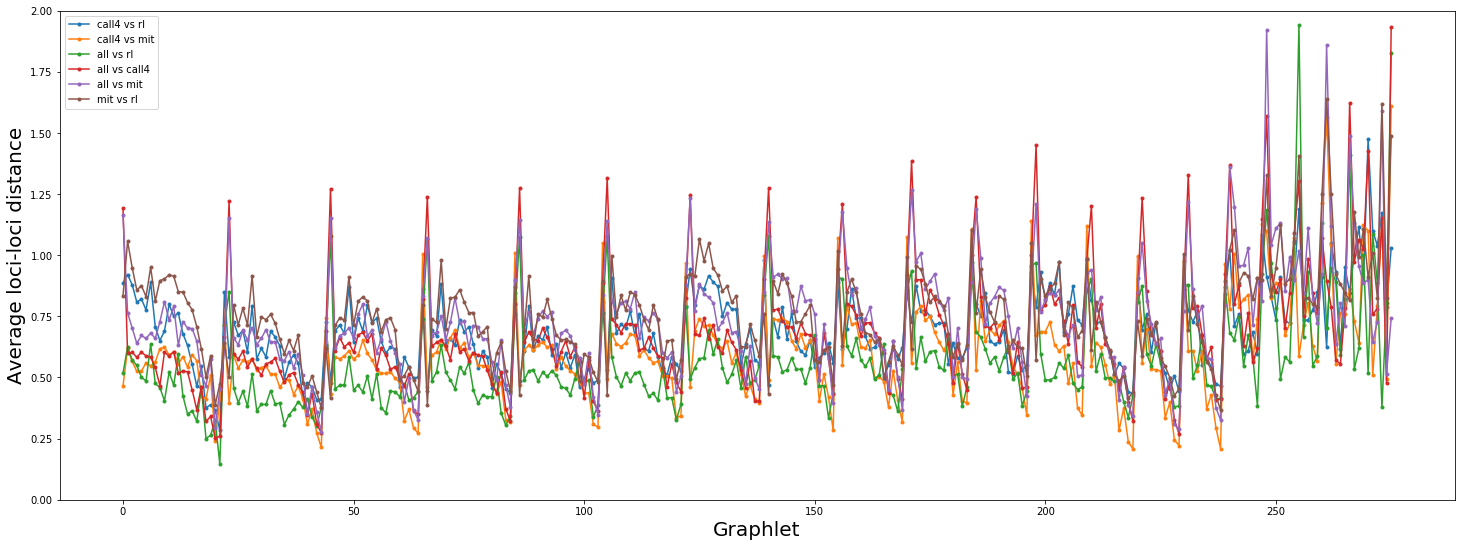

In [107]:
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(len(distances['mit']['rl']))
ax = plt.subplot(1, 1, 1)
for cell1 in distances:
    for cell2 in distances[cell1]:
        if cell1 >= cell2:
            continue
        y = distances[cell1][cell2][:, 0]
        ax.plot(x, y, marker=".", label="%s vs %s"%(cell1, cell2))
        ax.set_ylim([0, 2])
        ax.set_ylabel('Average loci-loci distance', fontsize=20)
        ax.set_xlabel('Graphlet', fontsize=20)

plt.legend()
plt.show()

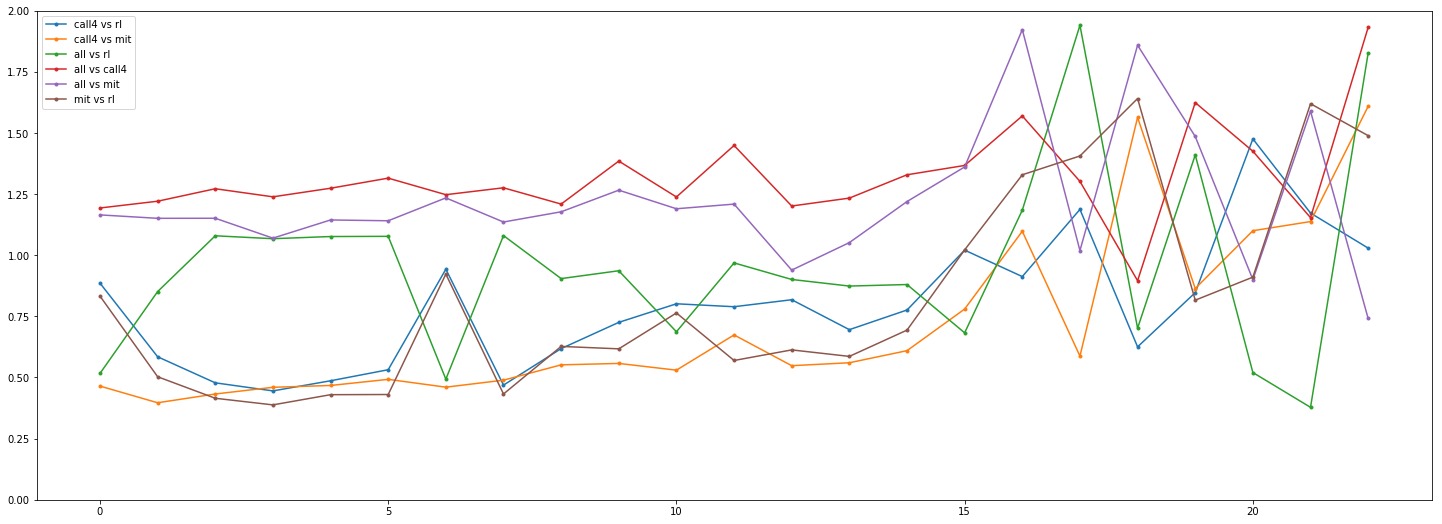

In [14]:
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(len(sameIndices))
ax = plt.subplot(1, 1, 1)
for cell1 in distances:
    for cell2 in distances[cell1]:
        if cell1 >= cell2:
            continue
        y = distances[cell1][cell2][sameIndices, 0]
        ax.plot(x, y, marker=".", label="%s vs %s"%(cell1, cell2))
        ax.set_ylim([0, 2])

plt.legend()
plt.show()

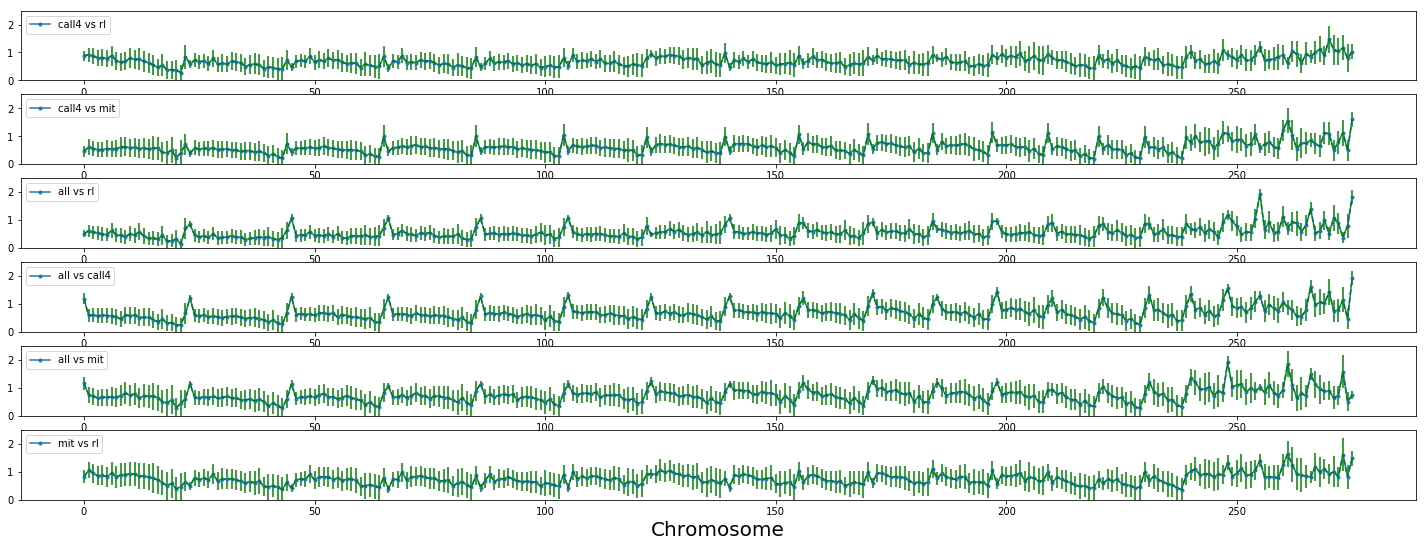

In [15]:
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(len(distances['mit']['rl']))
count = 1
for cell1 in distances:
    for cell in distances[cell1]:
        if cell <= cell1:
            continue
        ax = plt.subplot(6, 1, count)
        count +=1
        y = distances[cell1][cell][:, 0]
        y_error = .5 * distances[cell1][cell][:,1]
        line2, = ax.plot(x, y, marker=".", label="%s vs %s"%(cell1, cell))
        ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
        ax.set_ylim([0., 2.5])
        ax.legend(handles=[line2], loc=2)
ax.set_xlabel("Chromosome", fontsize=20)
plt.show()

### MIT vs Cancer average signature distance

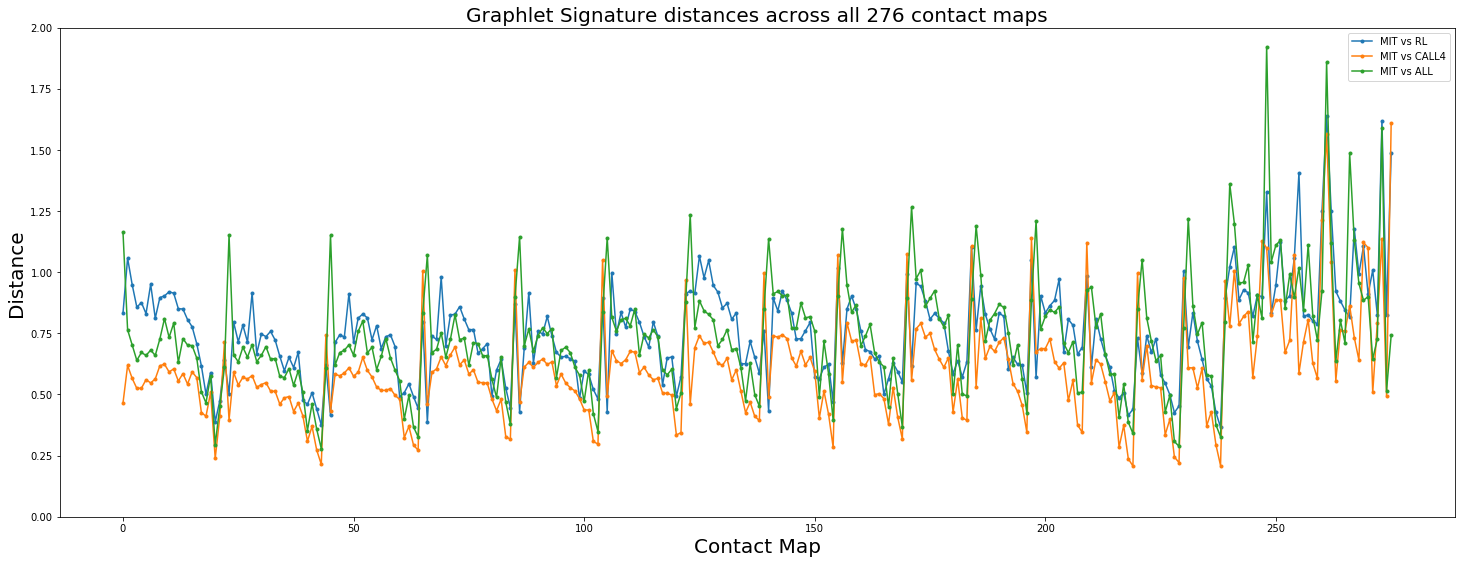

In [123]:
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(len(distances['mit']['rl']))
ax = plt.subplot(1, 1, 1)
ax.set_title("Graphlet Signature distances across all 276 contact maps"
            , fontsize=20)
ax.set_xlabel("Contact Map", fontsize=20)
ax.set_ylabel("Distance", fontsize=20)
for cell in distances['mit']:
    y = distances['mit'][cell][:, 0]
    ax.plot(x, y, marker=".", label="MIT vs %s"%cell.upper())
    ax.set_ylim([0, 2])

plt.legend()
plt.show()

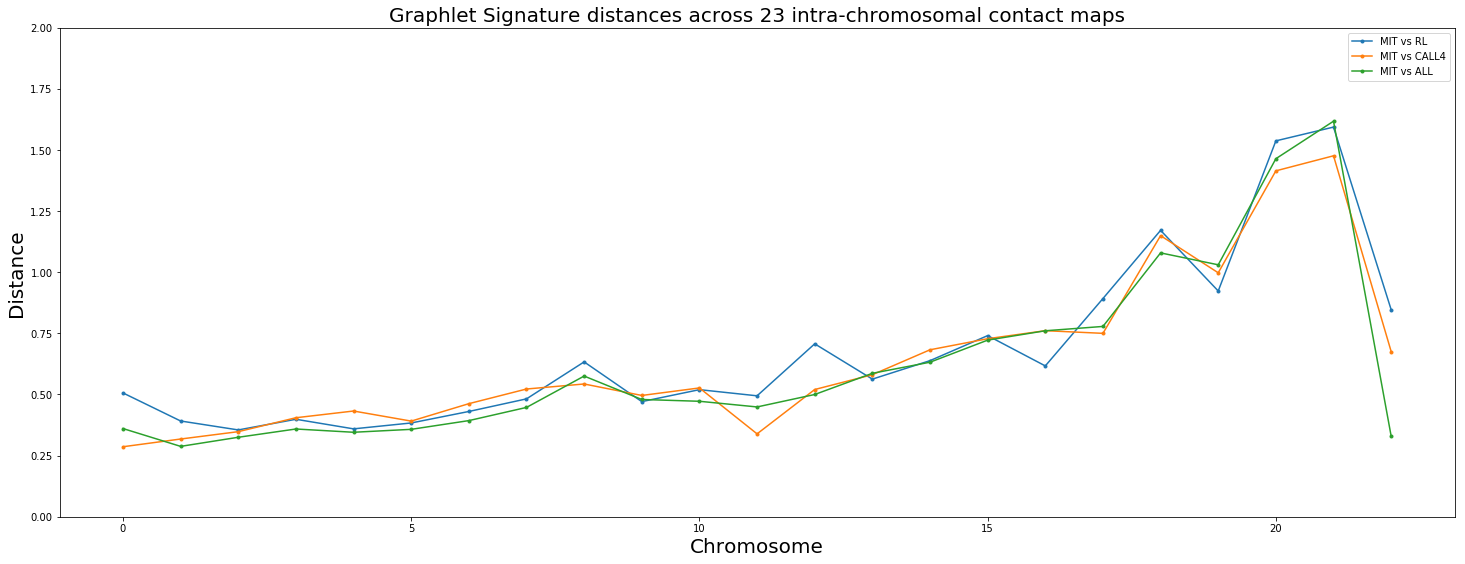

In [119]:
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(len(sameIndices))
ax = plt.subplot(1, 1, 1)
ax.set_title("Graphlet Signature distances across 23 intra-chromosomal contact maps"
            , fontsize=20)
ax.set_xlabel("Chromosome", fontsize=20)
ax.set_ylabel("Distance", fontsize=20)
for cell in distances['mit']:
    y = distances['mit'][cell][sameIndices, 0]
    ax.plot(x, y, marker=".", label="MIT vs %s"%cell.upper())
    ax.set_ylim([0, 2])

plt.legend()
plt.show()

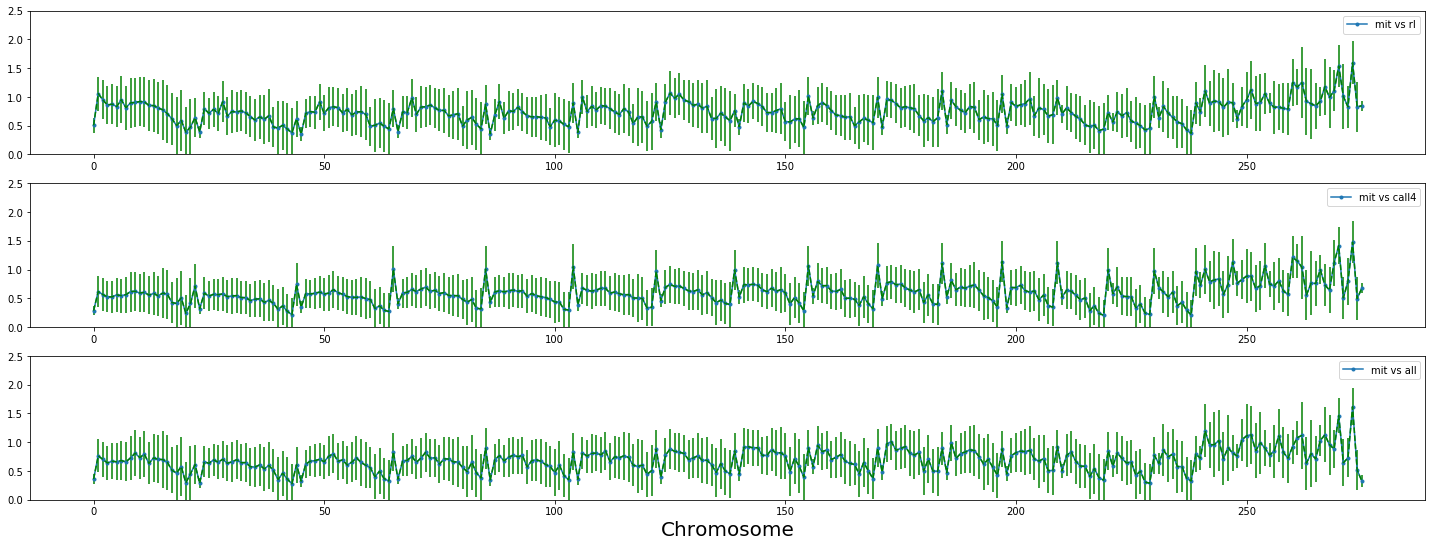

In [102]:
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(len(distances['mit']['rl']))
count = 1
for cell in distances['mit']:
    ax = plt.subplot(3, 1, count)
    count +=1
    y = distances['mit'][cell][:, 0]
    y_error = .5 * distances['mit'][cell][:,1]
    ax.plot(x, y, marker=".", label="mit vs %s"%cell)
    ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
    ax.set_ylim([0., 2.5])
    ax.legend()
ax.set_xlabel("Chromosome", fontsize=20)
plt.show()

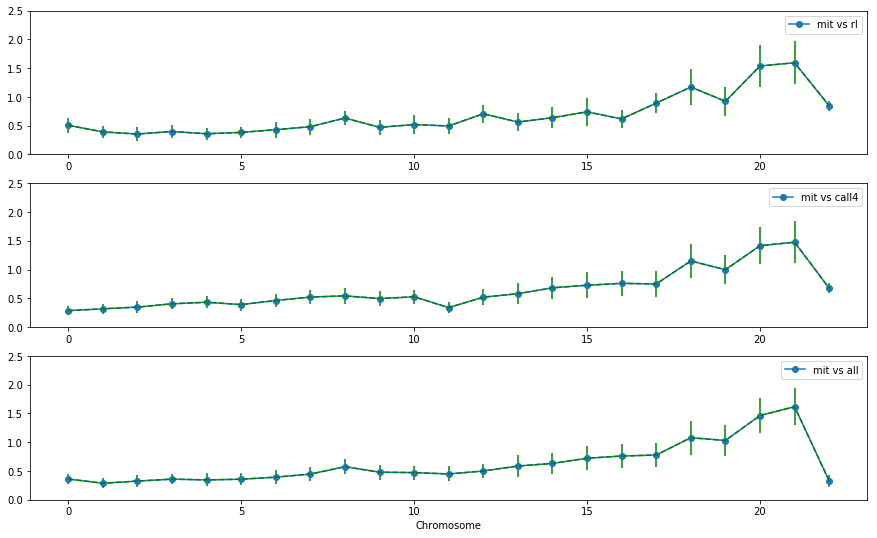

In [45]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(len(sameIndices))
count = 1
for cell in distances['mit']:
    ax = plt.subplot(3, 1, count)
    count +=1
    y = distances['mit'][cell][sameIndices, 0]
    y_error = .5 * distances['mit'][cell][sameIndices,1]
    ax.plot(x, y, marker="o", label="mit vs %s"%cell)
    ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
    ax.set_ylim([0., 2.5])
    ax.legend()
ax.set(xlabel="Chromosome")
plt.show()

### Cancer vs Cancer average distance vector

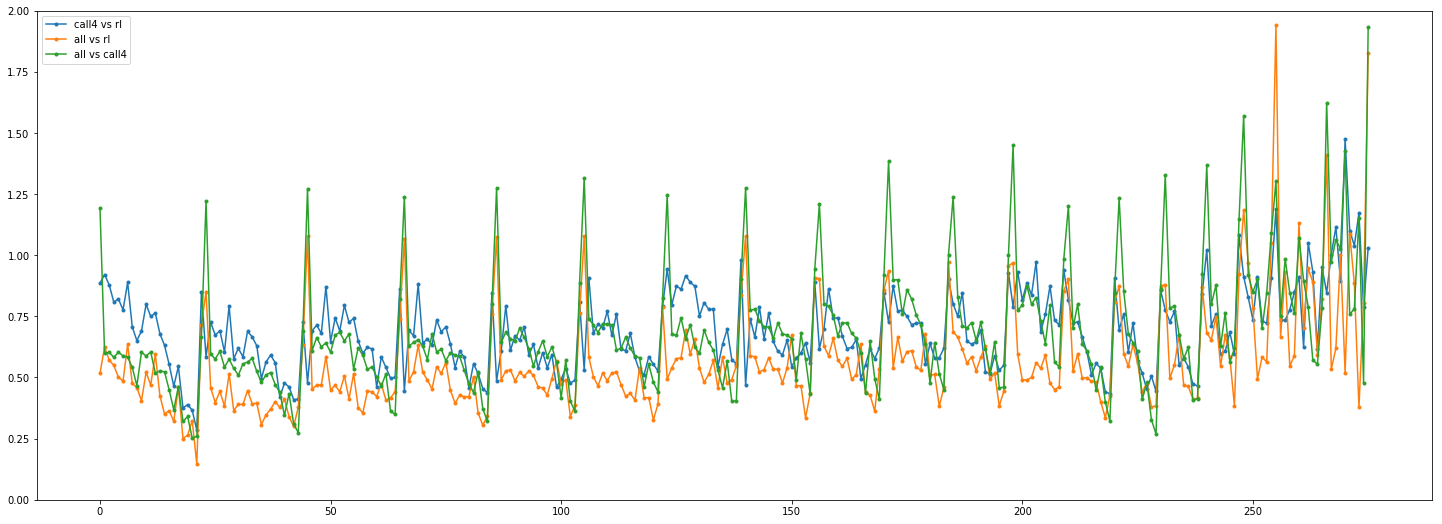

In [124]:
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(len(distances['mit']['rl']))
ax = plt.subplot(1, 1, 1)
for cell1 in distances:
    if cell1 == 'mit':
        continue
    for cell2 in distances[cell1]:
        if cell2 == 'mit' or cell1 >= cell2:
            continue
        y = distances[cell1][cell2][:, 0]
        ax.plot(x, y, marker=".", label="%s vs %s"%(cell1, cell2))
        ax.set_ylim([0, 2])

plt.legend()
plt.show()

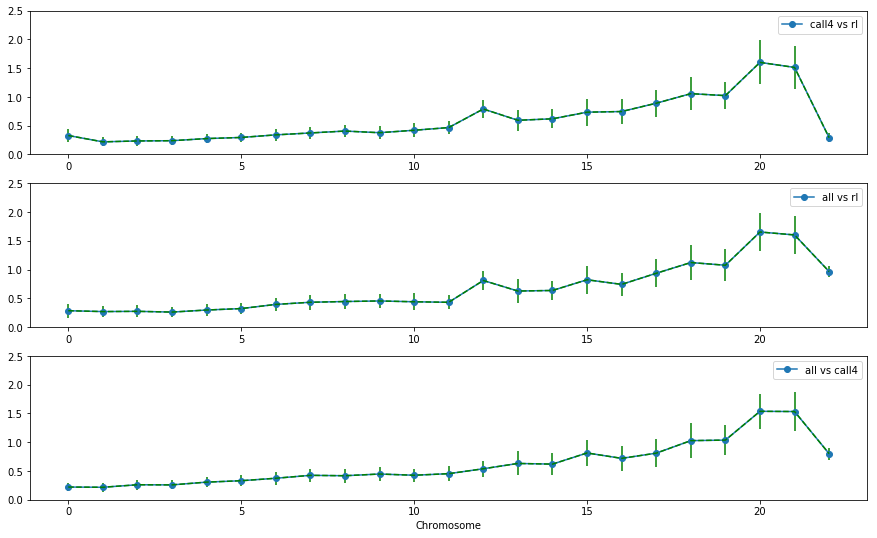

In [47]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(len(sameIndices))
count = 1
for cell1 in distances:
    if cell1 == 'mit':
        continue
    for cell2 in distances[cell1]:
        if cell2 < cell1 or cell2 == 'mit':
            continue
        ax = plt.subplot(3, 1, count)
        count +=1
        y = distances[cell1][cell2][sameIndices, 0]
        y_error = .5*distances[cell1][cell2][sameIndices,1]
        ax.plot(x, y, marker="o", label="%s vs %s"%(cell1, cell2))
        ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
        ax.set_ylim([0., 2.5])
        ax.legend()
ax.set(xlabel="Chromosome")
plt.show()

## Statistical Analysis
We performed a pairwise t-test (with $\alpha = 0.5$ 
between each pair of cell distances (including a comparison with 0) for 
each graphlet. The results are calculated in the following block. As can be viewed, All pairwise distances
are significantly larger than 0 

In [302]:
for chr1 in range(1, 24):
    for chr2 in range(chr1, 24):
        cmi = chr2count[(chr1, chr2)]
        a = []
        labels = []
        for cell1 in data_names:
            cell1 = cell1.lower()
            for cell2 in data_names:
                cell2 = cell2.lower()
                if cell2 <= cell1:
                    continue
                cm = actual_distances[cell1][cell2][cmi]
                a.append(cm)
                labels.append("%s-%s"%(cell1, cell2))
        zero_array = np.zeros_like(cm)               
        a.append(zero_array)
        labels.append("zero")
        out, text = compare_pairwise(a, labels=labels)
        print("%2d %2d %s"%(chr1, chr2, text))

 1  1        zero  <  call4-mit  <     all-rl  <     mit-rl  <   call4-rl  <    all-mit  =  all-call4
 1  2        zero  <     all-rl  =  all-call4  =  call4-mit  <    all-mit  <   call4-rl  <     mit-rl
 1  3        zero  <     all-rl  =  all-call4  =  call4-mit  <    all-mit  <   call4-rl  <     mit-rl
 1  4        zero  <     all-rl  =  all-call4  =  call4-mit  <    all-mit  <   call4-rl  <     mit-rl
 1  5        zero  <     all-rl  =  call4-mit  <  all-call4  <    all-mit  <   call4-rl  <     mit-rl
 1  6        zero  <     all-rl  <  all-call4  =  call4-mit  <    all-mit  <   call4-rl  <     mit-rl
 1  7        zero  <  all-call4  =  call4-mit  <    all-mit  =     all-rl  <   call4-rl  <     mit-rl
 1  8        zero  <     all-rl  <  all-call4  =  call4-mit  <    all-mit  =   call4-rl  <     mit-rl
 1  9        zero  <     all-rl  =  all-call4  <  call4-mit  =   call4-rl  <    all-mit  <     mit-rl
 1 10        zero  <     all-rl  <  all-call4  =  call4-mit  <   call4-rl  <    al

 4 23        zero  <     all-rl  =  all-call4  =     mit-rl  =    all-mit  =   call4-rl  <  call4-mit
 5  5        zero  <     mit-rl  =  call4-mit  =   call4-rl  <     all-rl  <    all-mit  <  all-call4
 5  6        zero  <     all-rl  <  all-call4  =  call4-mit  =     mit-rl  =    all-mit  =   call4-rl
 5  7        zero  <     all-rl  <  all-call4  =  call4-mit  <    all-mit  =   call4-rl  <     mit-rl
 5  8        zero  <     all-rl  <     mit-rl  =  all-call4  =  call4-mit  =    all-mit  =   call4-rl
 5  9        zero  <     all-rl  <  all-call4  =  call4-mit  =   call4-rl  <     mit-rl  =    all-mit
 5 10        zero  <     all-rl  <  call4-mit  =   call4-rl  <     mit-rl  =    all-mit  =  all-call4
 5 11        zero  <     all-rl  <  all-call4  =  call4-mit  <    all-mit  =   call4-rl  <     mit-rl
 5 12        zero  <     all-rl  <  all-call4  =  call4-mit  =   call4-rl  <     mit-rl  =    all-mit
 5 13        zero  <     all-rl  =    all-mit  =  all-call4  =  call4-mit  <     m

10 12        zero  <     all-rl  <  call4-mit  =   call4-rl  <     mit-rl  =  all-call4  <    all-mit
10 13        zero  <     all-rl  <  all-call4  =  call4-mit  =   call4-rl  <     mit-rl  =    all-mit
10 14        zero  <     all-rl  <  call4-mit  =     mit-rl  =  all-call4  =    all-mit  =   call4-rl
10 15        zero  <     all-rl  =  call4-mit  =   call4-rl  <     mit-rl  =  all-call4  <    all-mit
10 16        zero  <     all-rl  <  call4-mit  <  all-call4  =     mit-rl  =    all-mit  =   call4-rl
10 17        zero  <     all-rl  <  call4-mit  <     mit-rl  =    all-mit  =  all-call4  =   call4-rl
10 18        zero  <   call4-rl  <     mit-rl  =     all-rl  =  all-call4  =  call4-mit  <    all-mit
10 19        zero  <     all-rl  =    all-mit  =  all-call4  =     mit-rl  =  call4-mit  =   call4-rl
10 20        zero  <     all-rl  =  call4-mit  =     mit-rl  =  all-call4  =    all-mit  =   call4-rl
10 21        zero  <     all-rl  =  call4-mit  <    all-mit  =     mit-rl  =  all-

# 3. Orbit-wise Correlation
<img src="papers/manuscripts/figures/graphlet_correlation_schema.png">

In [129]:
cells = ['mit', 'all', 'rl', 'call4']
chr2count = {}
count2chr = {}
count = 0
for chr1 in range(1, 24):
    for chr2 in range(chr1, 24):
        chr2count[(chr1, chr2)] = count
        count2chr[count] = (chr1, chr2)
        count += 1
        
correlations = {}
for cell in cells:
    correlations[cell] = {}
    
for cell1 in cells:
    for cell2 in cells:
        if cell2 <= cell1:
            continue
        correlations[cell1][cell2] = np.zeros((count, 73))
        correlations[cell2][cell1] = correlations[cell1][cell2]
        #cell (i, j) will store correlation between orbital j in 
        #ith chromosome
        
for cell1 in cells:
    for cell2 in cells:
        if cell2 <= cell1:
            continue
        print(cell1, cell2)
        count = 0 
        for chr1 in range(1, 24):
            for chr2 in range(chr1, 24):
                correlations[cell1][cell2][count, :] =  row_wise_pearson(graphlets[cell1][chr1][chr2].T\
                                , graphlets[cell2][chr1][chr2].T)
                count+=1

('mit', 'rl')
('all', 'mit')
('all', 'rl')
('all', 'call4')
('call4', 'mit')
('call4', 'rl')


### MIT vs Cancer Graphlet Orbit Correlaiton Comparison

(276, 73)


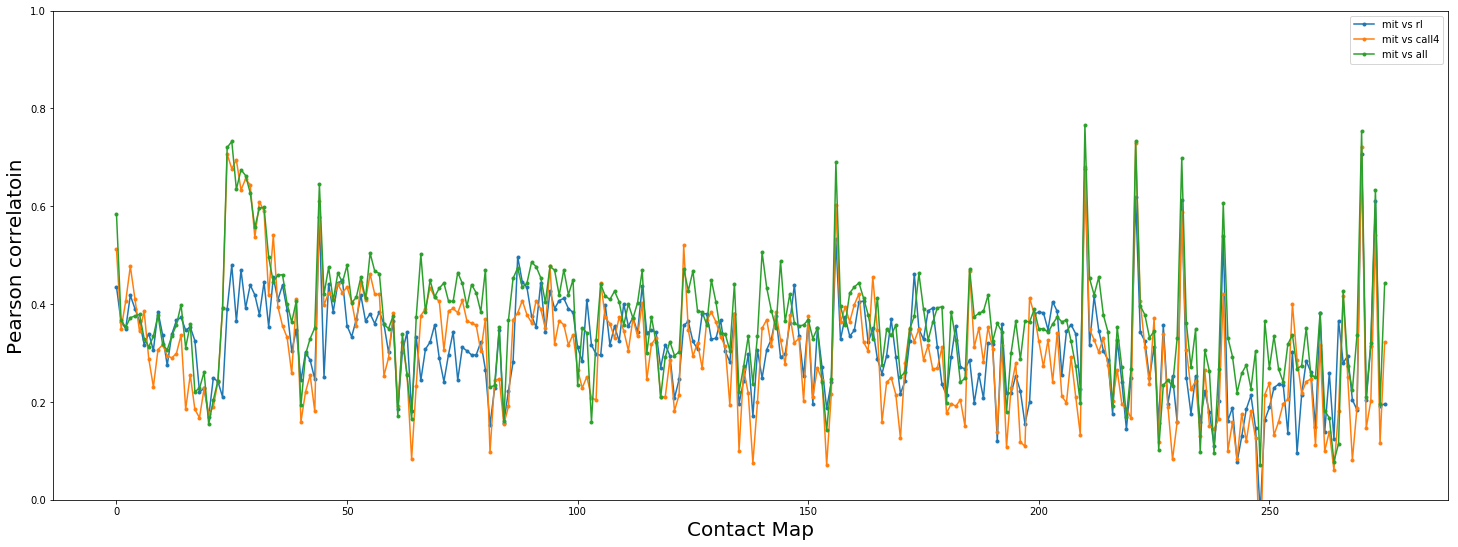

In [137]:
print(correlations['mit']['rl'].shape)
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(len(correlations['mit']['rl']))
ax = plt.subplot(1, 1, 1)
for cell in correlations['mit']:
    y = np.nanmean(correlations['mit'][cell][:,indices], axis=1)
    ax.plot(x, y, marker=".", label="mit vs %s"%cell)
    ax.set_ylim([0, 1])
    ax.set_xlabel("Contact Map", fontsize=20)
    ax.set_ylabel("Pearson correlatoin", fontsize=20)
plt.legend()
plt.show()

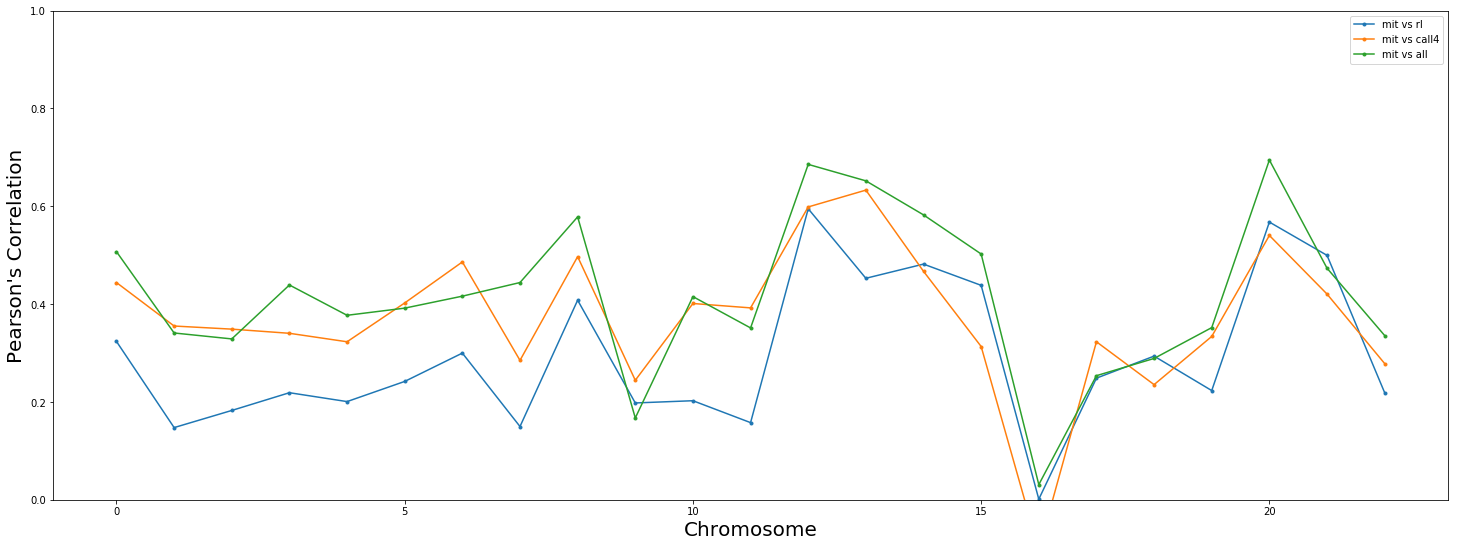

In [134]:
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(len(sameIndices))
ax = plt.subplot(1, 1, 1)
for cell in correlations['mit']:
    y = np.nanmean(correlations['mit'][cell][sameIndices,:], axis=1)
    ax.plot(x, y, marker=".", label="mit vs %s"%cell)
    ax.set(ylim=[0, 1])
    ax.set_xlabel('Chromosome', fontsize=20)
    ax.set_ylabel('Pearson\'s Correlation', fontsize=20)
plt.legend()
plt.show()

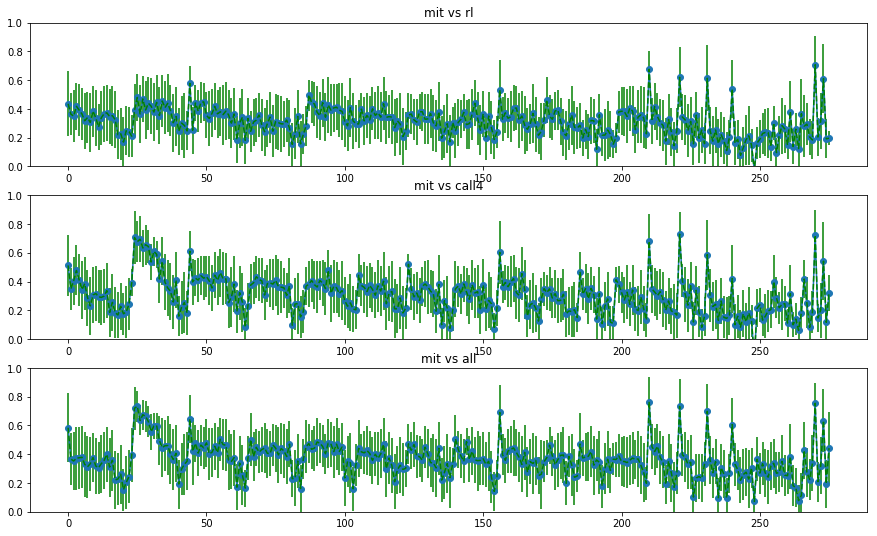

In [135]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(len(correlations['mit']['rl']))
count = 1
for cell in correlations['mit']:
    ax = plt.subplot(3, 1, count)
    count += 1
    temp = correlations['mit'][cell][:,indices]
    y = np.nanmean(temp, axis=1)
    y_error = np.nanstd(temp, axis=1)
    ax.plot(x, y, marker="o", label="mit vs %s"%cell)
    ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
    ax.set_title("mit vs %s"%cell)
    ax.set_ylim([0, 1])
plt.show()

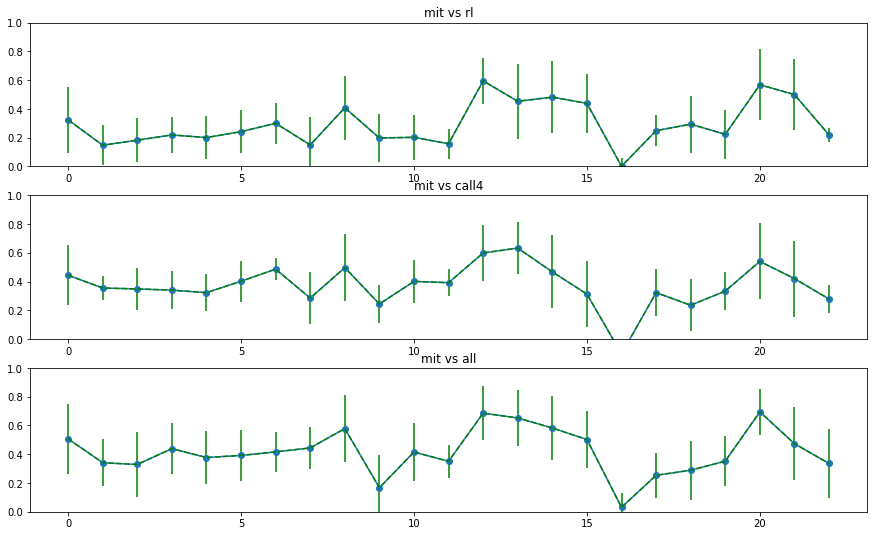

In [138]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(len(sameIndices))
count = 1
for cell in correlations['mit']:
    ax = plt.subplot(3, 1, count)
    count += 1
    temp = correlations['mit'][cell][sameIndices, :]
    y = np.nanmean(temp, axis=1)
    y_error = np.nanstd(temp, axis=1)
    ax.plot(x, y, marker="o", label="mit vs %s"%cell)
    ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
    ax.set_title("mit vs %s"%cell)
    ax.set_ylim([0, 1])
plt.show()

## Statistical Analysis

In [307]:
for chr1 in range(1, 24):
    for chr2 in range(chr1, 24):
        cmi = chr2count[(chr1, chr2)]
        a = []
        labels = []
        for cell1 in data_names:
            cell1 = cell1.lower()
            for cell2 in data_names:
                cell2 = cell2.lower()
                if cell2 <= cell1:
                    continue
                cm = correlations[cell1][cell2][cmi]
                a.append(cm)
                labels.append("%s-%s"%(cell1, cell2))
        zero_array = np.zeros_like(cm)               
        a.append(zero_array)
        labels.append("zero")
        out, text = compare_pairwise(a, labels=labels)
        print("%2d %2d %s"%(chr1, chr2, text))

 1  1        zero  <     mit-rl  <  call4-mit  <    all-mit  =     all-rl  <   call4-rl  <  all-call4
 1  2        zero  <     mit-rl  =    all-mit  =  call4-mit  =   call4-rl  <     all-rl  =  all-call4
 1  3        zero  <     mit-rl  =    all-mit  <  call4-mit  <     all-rl  =  all-call4  =   call4-rl
 1  4        zero  <    all-mit  <     mit-rl  <     all-rl  =  all-call4  =  call4-mit  <   call4-rl
 1  5        zero  <     mit-rl  =    all-mit  <  call4-mit  <     all-rl  <  all-call4  =   call4-rl
 1  6        zero  <  call4-mit  <     mit-rl  =    all-mit  <     all-rl  <  all-call4  =   call4-rl
 1  7        zero  <     mit-rl  =    all-mit  <  call4-mit  <     all-rl  <  all-call4  =   call4-rl
 1  8        zero  <    all-mit  =     mit-rl  =  call4-mit  <     all-rl  <  all-call4  =   call4-rl
 1  9        zero  <  call4-mit  <     mit-rl  =    all-mit  <  all-call4  <     all-rl  =   call4-rl
 1 10        zero  <  call4-mit  <     mit-rl  =    all-mit  <  all-call4  <     a

 4 22        zero  <     mit-rl  =    all-mit  =  call4-mit  <  all-call4  <     all-rl  =   call4-rl
 4 23        zero  <  all-call4  =  call4-mit  <     mit-rl  =     all-rl  <    all-mit  =   call4-rl
 5  5        zero  <     mit-rl  <  call4-mit  <     all-rl  <    all-mit  <  all-call4  <   call4-rl
 5  6        zero  <  call4-mit  <    all-mit  <     mit-rl  <     all-rl  =  all-call4  <   call4-rl
 5  7        zero  <  call4-mit  <     mit-rl  =    all-mit  <  all-call4  <     all-rl  <   call4-rl
 5  8        zero  <  call4-mit  <     mit-rl  =    all-mit  <     all-rl  <  all-call4  <   call4-rl
 5  9        zero  <     mit-rl  =  call4-mit  <     all-rl  <    all-mit  <  all-call4  =   call4-rl
 5 10        zero  <     mit-rl  <  call4-mit  <    all-mit  =     all-rl  =  all-call4  <   call4-rl
 5 11        zero  <  call4-mit  <     mit-rl  =    all-mit  <     all-rl  <  all-call4  <   call4-rl
 5 12        zero  <     mit-rl  =  call4-mit  <    all-mit  <     all-rl  <  all-

 9 23        zero  <  all-call4  =  call4-mit  <     mit-rl  =     all-rl  <    all-mit  =   call4-rl
10 10        zero  <    all-mit  <     mit-rl  <  call4-mit  <  all-call4  <     all-rl  <   call4-rl
10 11        zero  <     mit-rl  =    all-mit  =  call4-mit  <     all-rl  =  all-call4  <   call4-rl
10 12        zero  <  call4-mit  <     mit-rl  =    all-mit  =     all-rl  =  all-call4  =   call4-rl
10 13        zero  <     mit-rl  =     all-rl  =  call4-mit  =   call4-rl  <    all-mit  =  all-call4
10 14        zero  <  call4-mit  <     mit-rl  <    all-mit  <     all-rl  =  all-call4  =   call4-rl
10 15        zero  <    all-mit  =  call4-mit  <     mit-rl  <   call4-rl  <     all-rl  =  all-call4
10 16        zero  <  call4-mit  <     mit-rl  =    all-mit  <     all-rl  =  all-call4  =   call4-rl
10 17        zero  <  call4-mit  <     mit-rl  <    all-mit  <     all-rl  =  all-call4  =   call4-rl
10 18        zero  <     mit-rl  <  call4-mit  <    all-mit  =     all-rl  =  all-

18 19        zero  <     mit-rl  <    all-mit  =     all-rl  =  call4-mit  =   call4-rl  <  all-call4
18 20        zero  <     mit-rl  =  call4-mit  <    all-mit  <   call4-rl  <  all-call4  <     all-rl
18 21        zero  <  call4-mit  <     mit-rl  =   call4-rl  <    all-mit  =  all-call4  <     all-rl
18 22        zero  <  all-call4  =   call4-rl  <     mit-rl  =    all-mit  =  call4-mit  <     all-rl
18 23        zero  <     all-rl  =     mit-rl  =  all-call4  =  call4-mit  =    all-mit  =   call4-rl
19 19        zero  <  call4-mit  <     mit-rl  =    all-mit  <     all-rl  <  all-call4  <   call4-rl
19 20        zero  <  call4-mit  <     mit-rl  <    all-mit  <  all-call4  <     all-rl  <   call4-rl
19 21        zero  <    all-mit  =  call4-mit  <     mit-rl  =     all-rl  =  all-call4  <   call4-rl
19 22        zero  <    all-mit  =  call4-mit  <     mit-rl  <     all-rl  =  all-call4  <   call4-rl
19 23        zero  <    all-mit  <     all-rl  =  call4-mit  <     mit-rl  =  all-

In [310]:
for o in range(73):
    a = []
    labels = []
    for cell1 in data_names:
        cell1 = cell1.lower()
        for cell2 in data_names:
            cell2 = cell2.lower()
            if cell2 <= cell1:
                continue
            cm = correlations[cell1][cell2][:, o]
            a.append(cm)
            labels.append("%s-%s"%(cell1, cell2))
    zero_array = np.zeros_like(cm)               
    a.append(zero_array)
    labels.append("zero")
    out, text = compare_pairwise(a, labels=labels)
    print("%2d %s"%(o, text))

 0        zero  <     mit-rl  =  call4-mit  <    all-mit  <     all-rl  =  all-call4  <   call4-rl
 1        zero  <     mit-rl  =  call4-mit  <    all-mit  <  all-call4  <     all-rl  =   call4-rl
 2        zero  <     mit-rl  =  call4-mit  <    all-mit  <     all-rl  =  all-call4  <   call4-rl
 3        zero  <     mit-rl  <    all-mit  =     all-rl  =  call4-mit  <  all-call4  =   call4-rl
 4        zero  <  call4-mit  <     mit-rl  <    all-mit  <  all-call4  <   call4-rl  <     all-rl
 5        zero  <     mit-rl  =  call4-mit  <    all-mit  <     all-rl  =  all-call4  <   call4-rl
 6        zero  <  call4-mit  <     mit-rl  <    all-mit  <  all-call4  =   call4-rl  <     all-rl
 7        zero  <     mit-rl  =  call4-mit  <    all-mit  <     all-rl  <  all-call4  <   call4-rl
 8        zero  <     mit-rl  =  call4-mit  <    all-mit  <  all-call4  <     all-rl  =   call4-rl
 9        zero  <     mit-rl  <     all-rl  =  call4-mit  =  all-call4  =    all-mit  =   call4-rl
10        

### MIT vs Cancer Orbit Distribution Comparison

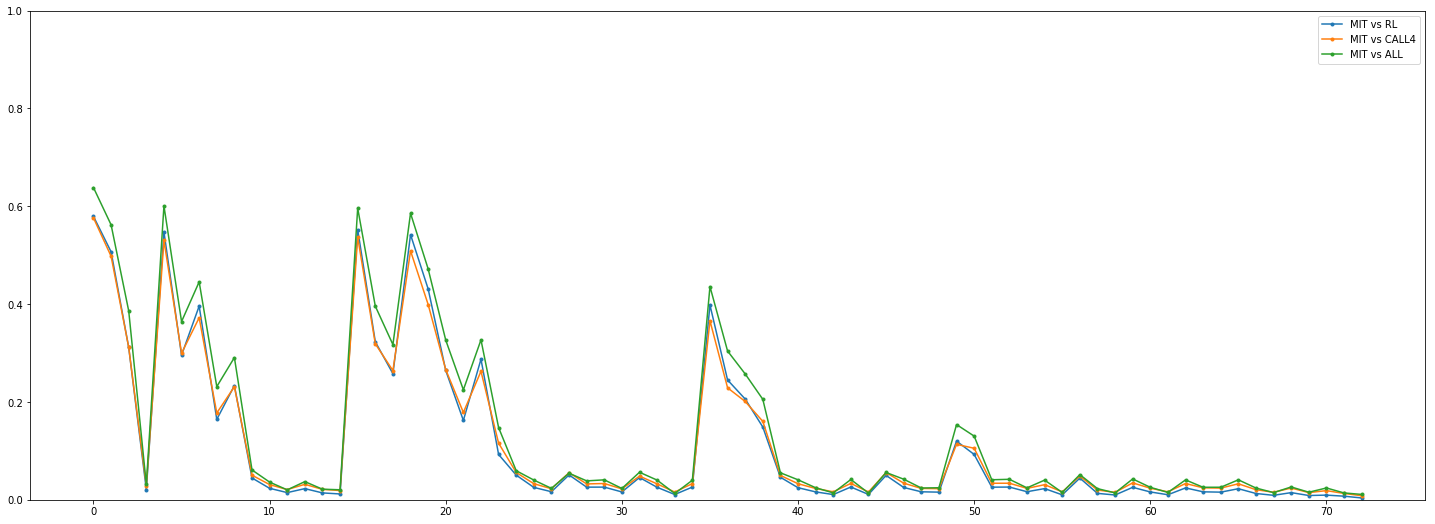

In [139]:
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(73)
ax = plt.subplot(1, 1, 1)
for cell in correlations['mit']:
    y = np.mean(correlations['mit'][cell][:,:], axis=0)
    ax.plot(x, y, marker=".", label="MIT vs %s"%cell.upper())
    ax.set_ylim([0, 1])
    
plt.legend()
plt.show()

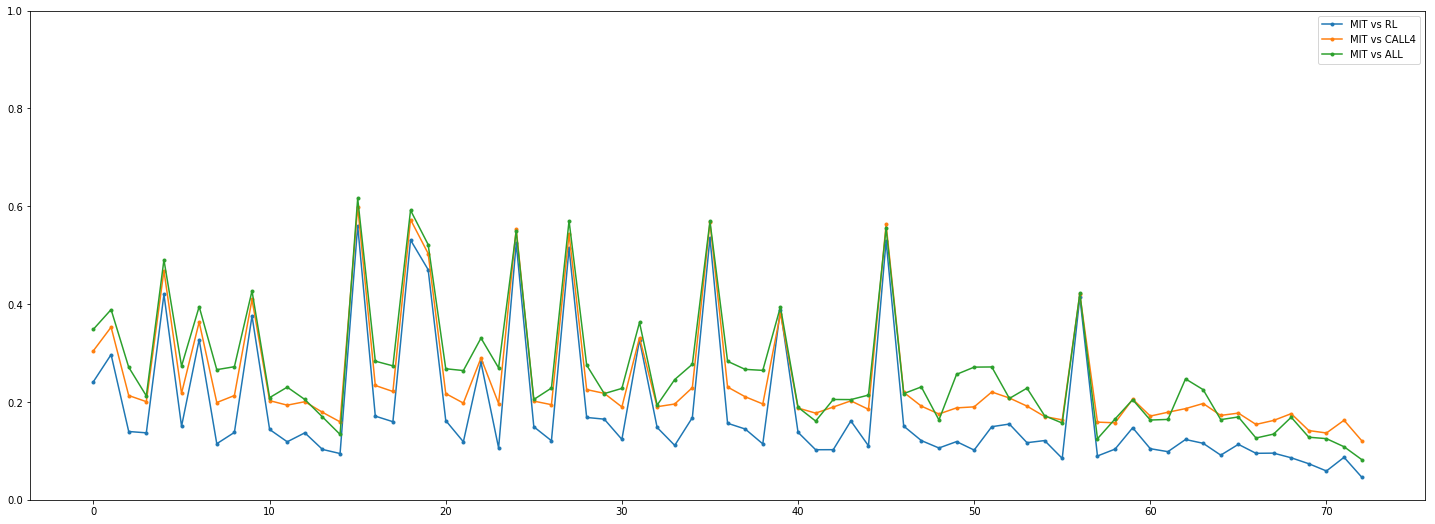

In [144]:
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(73)
ax = plt.subplot(1, 1, 1)
for cell in correlations['mit']:
    y = np.mean(correlations['mit'][cell][sameIndices,:], axis=0)
    ax.plot(x, y, marker=".", label="MIT vs %s"%cell.upper())
    ax.set_ylim([0, 1])
    
plt.legend()
plt.show()

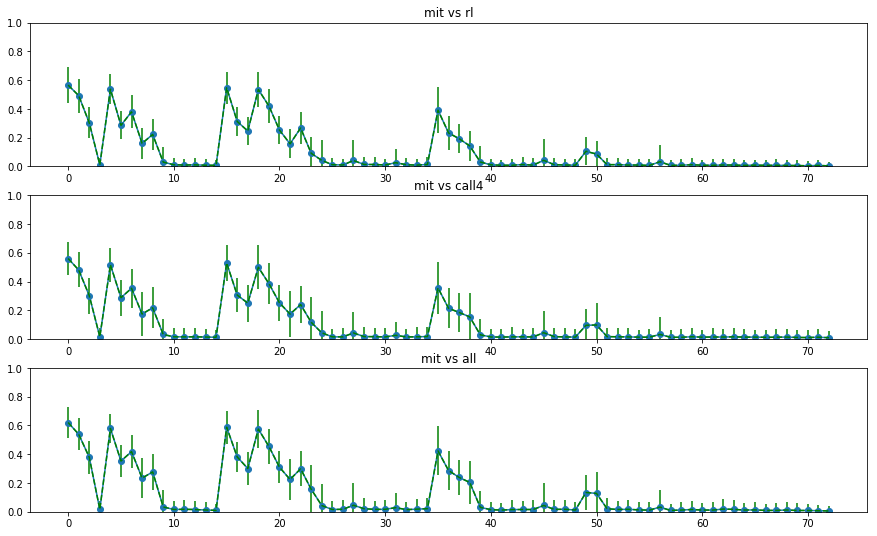

In [79]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(0, 73)
count = 1
for cell in correlations['mit']:
    ax = plt.subplot(3, 1, count)
    count += 1
    y = np.mean(correlations['mit'][cell][1:,:], axis=0)
    y_error = np.std(correlations['mit'][cell][1:,:], axis=0)
    ax.plot(x, y, marker="o", label="mit vs %s"%cell)
    ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
    ax.set_title("mit vs %s"%cell)
    ax.set_ylim([0, 1])

plt.show()

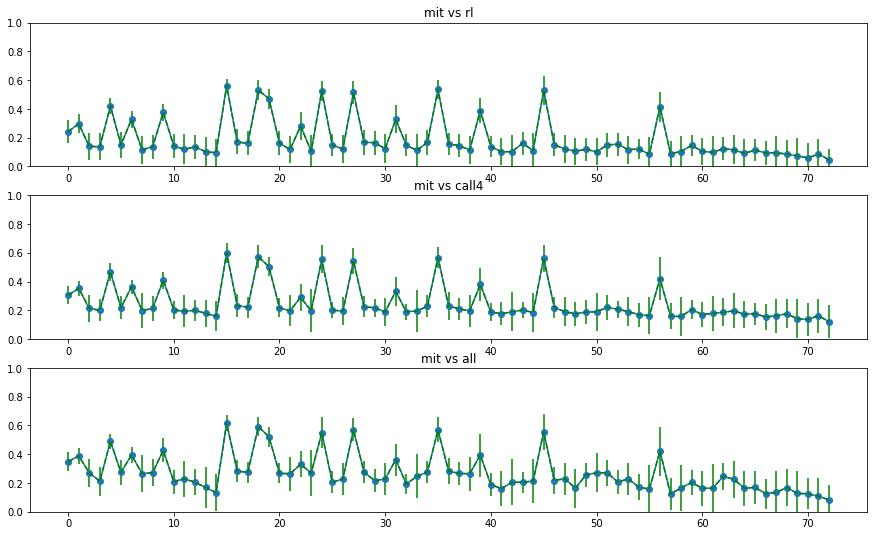

In [80]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(73)
count = 1
for cell in correlations['mit']:
    ax = plt.subplot(3, 1, count)
    count += 1
    y = np.mean(correlations['mit'][cell][sameIndices,:], axis=0)
    y_error = np.std(correlations['mit'][cell][sameIndices,:], axis=0)
    ax.plot(x, y, marker="o", label="mit vs %s"%cell)
    ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
    ax.set_title("mit vs %s"%cell)
    ax.set_ylim([0, 1])

plt.show()

# Cancer vs Cancer contact map orbit correlation comparison

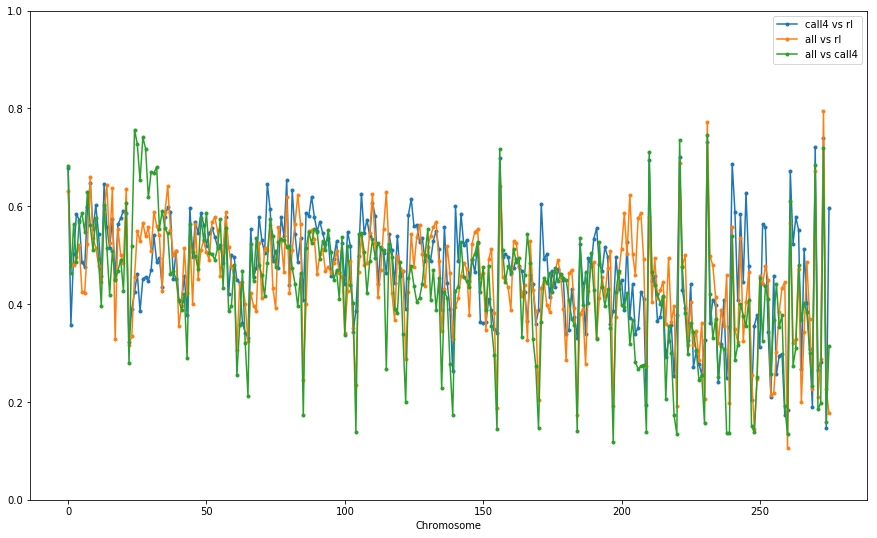

In [140]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(len(correlations['mit']['rl']))
ax = plt.subplot(1, 1, 1)
for cell1 in correlations:
    if cell1 == 'mit':
        continue
    for cell2 in correlations[cell1]:
        if cell2 == 'mit' or cell1 > cell2:
            continue
        y = np.nanmean(correlations[cell1][cell2][:,indices], axis=1)
        ax.plot(x, y, marker=".", label="%s vs %s"%(cell1, cell2))
        ax.set(ylim=[0, 1], xlabel='Chromosome')
plt.legend()
plt.show()

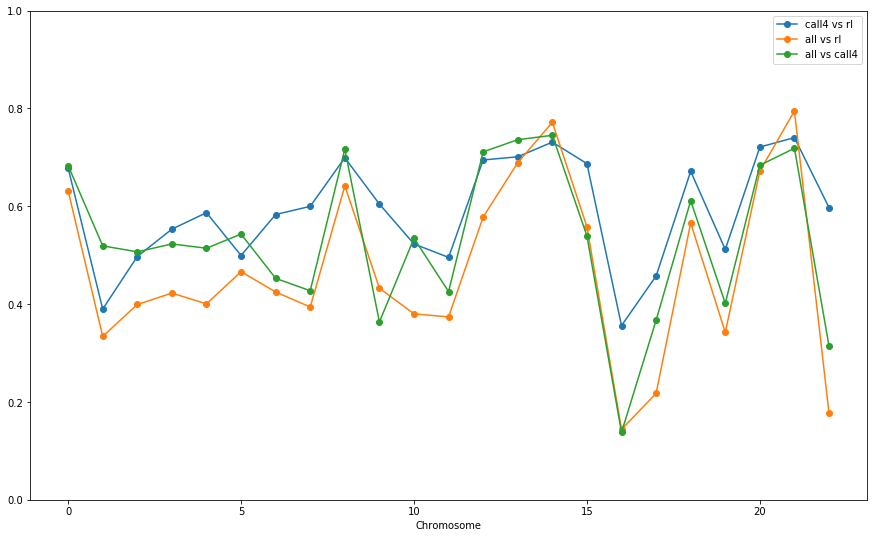

In [141]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(len(sameIndices))
ax = plt.subplot(1, 1, 1)
for cell1 in correlations:
    if cell1 == 'mit':
        continue
    for cell2 in correlations[cell1]:
        if cell2 == 'mit' or cell1 > cell2:
            continue
        y = np.nanmean(correlations[cell1][cell2][sameIndices, :][:, indices], axis=1)
        ax.plot(x, y, marker="o", label="%s vs %s"%(cell1, cell2))
        ax.set(ylim=[0, 1], xlabel='Chromosome')
plt.legend()
plt.show()

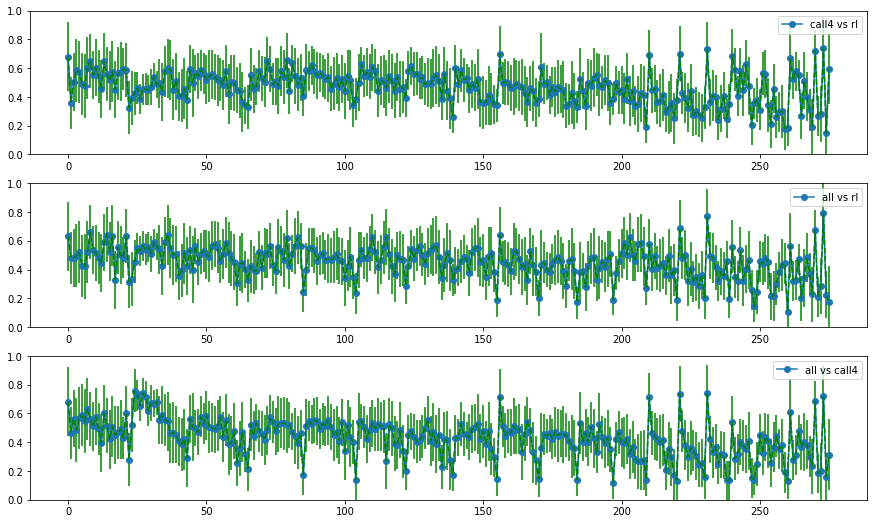

In [142]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(len(correlations['mit']['rl']))
count = 1
for cell1 in correlations:
    if cell1 == 'mit':
        continue
    for cell2 in correlations[cell1]:
        if cell2 == 'mit' or cell1 > cell2:
            continue
        ax = plt.subplot(3, 1, count)
        count += 1
        y = np.nanmean(correlations[cell1][cell2][:,indices], axis=1)
        y_error = np.nanstd(correlations['mit'][cell][:,indices], axis=1)
        ax.plot(x, y, marker="o", label="%s vs %s"%(cell1, cell2))
        ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
        ax.legend()
        ax.set_ylim([0, 1])
plt.show()

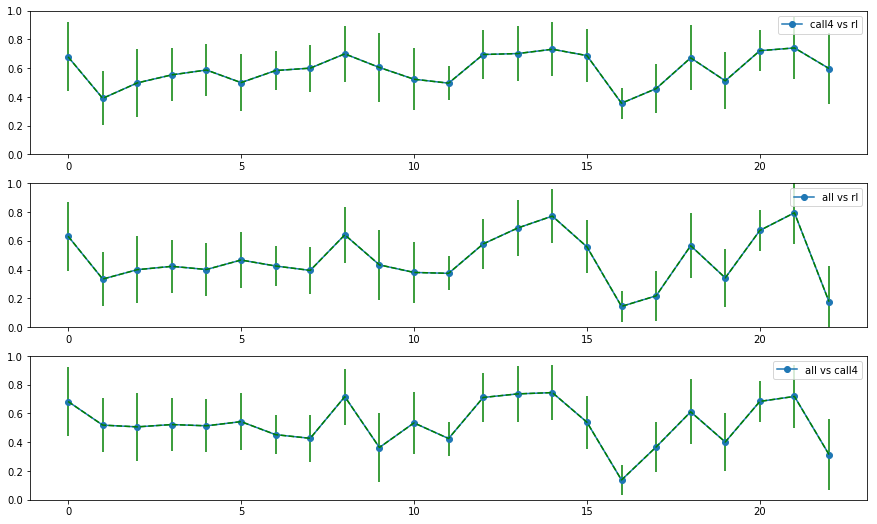

In [143]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(len(sameIndices))
count = 1
for cell1 in correlations:
    if cell1 == 'mit':
        continue
    for cell2 in correlations[cell1]:
        if cell2 == 'mit' or cell1 > cell2:
            continue
        ax = plt.subplot(3, 1, count)
        count += 1
        y = np.nanmean(correlations[cell1][cell2][sameIndices, :][:,indices], axis=1)
        y_error = np.nanstd(correlations['mit'][cell][sameIndices, :][:,indices], axis=1)
        ax.plot(x, y, marker="o", label="%s vs %s"%(cell1, cell2))
        ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
        ax.legend()
        ax.set_ylim([0, 1])
plt.show()

### Cancer vs Cancer Orbit correlation

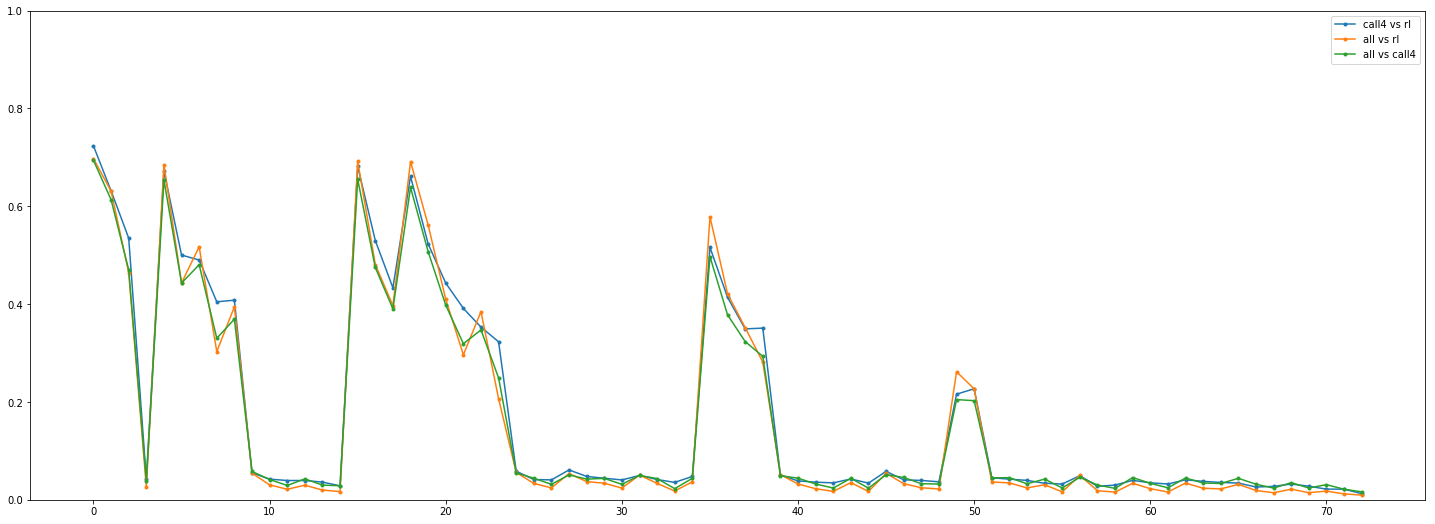

In [144]:
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(0, 73)
ax = plt.subplot(1, 1, 1)
for cell1 in correlations:
    if cell1 == 'mit':
        continue
    for cell2 in correlations[cell1]:
        if cell2 == 'mit' or cell1 > cell2:
            continue
        y = np.mean(correlations[cell1][cell2][:,:], axis=0)
        ax.plot(x, y, marker=".", label="%s vs %s"%(cell1, cell2))
        ax.set_ylim([0, 1])
plt.legend()
plt.show()

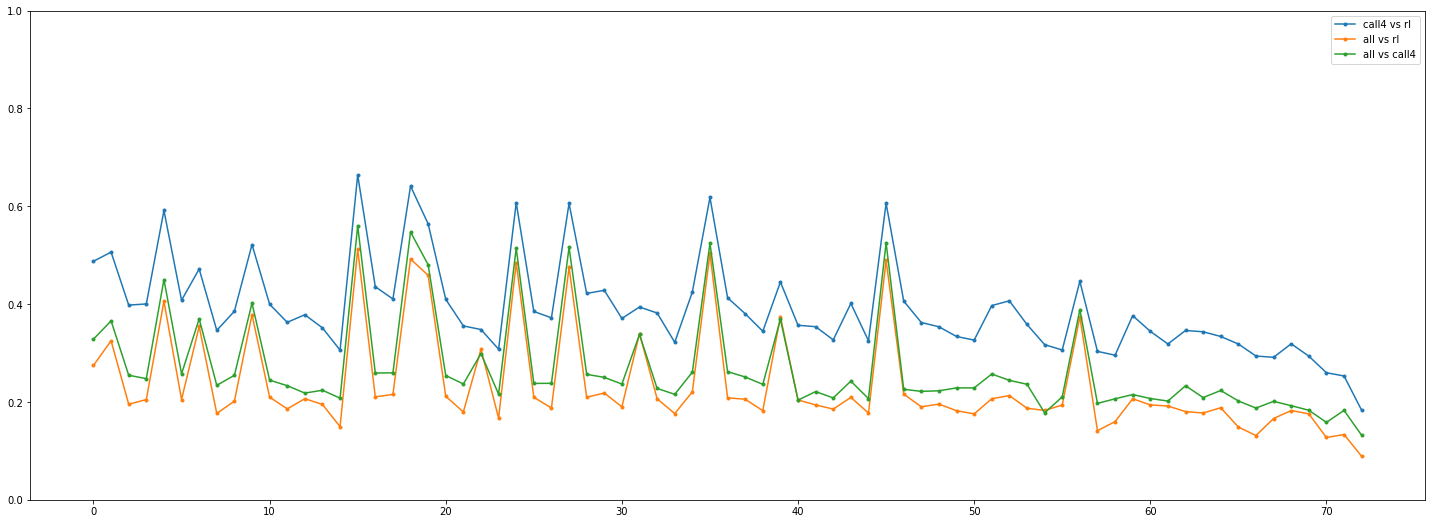

In [140]:
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(0, 73)
ax = plt.subplot(1, 1, 1)
for cell1 in correlations:
    if cell1 == 'mit':
        continue
    for cell2 in correlations[cell1]:
        if cell2 == 'mit' or cell1 > cell2:
            continue
        y = np.mean(correlations[cell1][cell2][sameIndices,:], axis=0)
        ax.plot(x, y, marker=".", label="%s vs %s"%(cell1, cell2))
        ax.set_ylim([0, 1])
plt.legend()
plt.show()

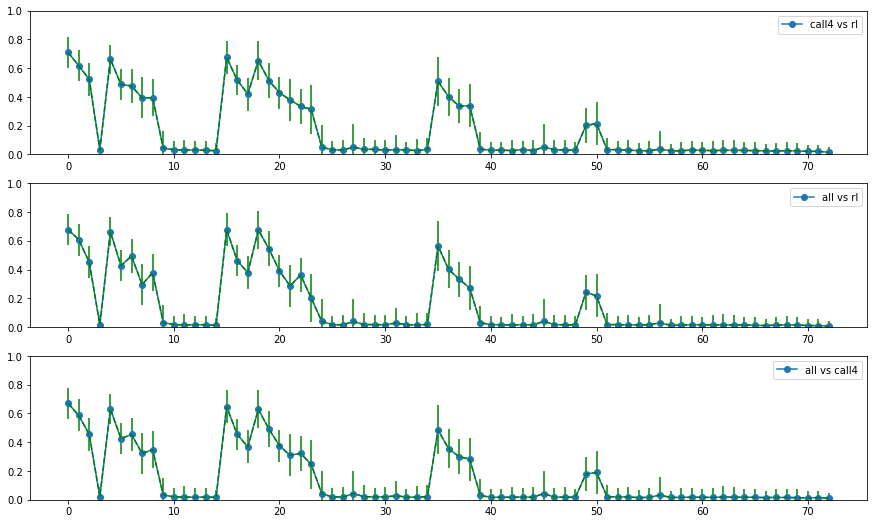

In [37]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(0, 73)
count = 1
for cell1 in correlations:
    if cell1 == 'mit':
        continue
    for cell2 in correlations[cell1]:
        if cell2 == 'mit' or cell1 > cell2:
            continue
        ax = plt.subplot(3, 1, count)
        count += 1
        y = np.mean(correlations[cell1][cell2][:,:], axis=0)
        y_error = np.std(correlations['mit'][cell][:,:], axis=0)
        ax.plot(x, y, marker="o", label="%s vs %s"%(cell1, cell2))
        ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
        ax.set_ylim([0, 1])
        ax.legend()
plt.show()

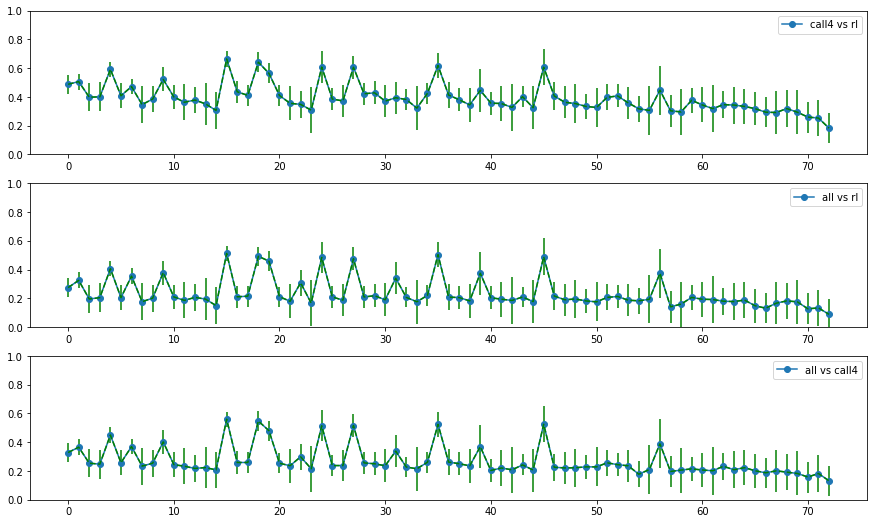

In [86]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(0, 73)
count = 1
for cell1 in correlations:
    if cell1 == 'mit':
        continue
    for cell2 in correlations[cell1]:
        if cell2 == 'mit' or cell1 > cell2:
            continue
        ax = plt.subplot(3, 1, count)
        count += 1
        y = np.mean(correlations[cell1][cell2][sameIndices,:], axis=0)
        y_error = np.std(correlations['mit'][cell][sameIndices,:], axis=0)
        ax.plot(x, y, marker="o", label="%s vs %s"%(cell1, cell2))
        ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
        ax.set_ylim([0, 1])
        ax.legend()
plt.show()

# MIC Analysis

In [5]:
#header = "MIT,ALL,RL,call4"
#for chr1 in range(1, 24):
#    for chr2 in range(chr1, 24):
#        for orbit in range(72, 73):
#            filename = "%s/data/chr%02d_chr%02d_orbit%02d.csv"%(root, chr1, chr2, orbit)
#            n = 100000000
#            for cell in data_names:
#                cell = cell.lower()
#                n = np.min([graphlets[cell][chr1][chr2][:, orbit].shape[0], n])
#            temp = np.zeros((n, len(data_names)))
#            count = 0
#            for cell in data_names:
#                cell = cell.lower()
#                temp[:, count] = graphlets[cell][chr1][chr2][:n, orbit]
#                count += 1
#            np.savetxt(filename, temp, delimiter=',', header=header)

In [6]:
#for chr1 in range(1, 24):
#    for chr2 in range(chr1, 24):
#        for orbit in range(73):
#            file_name = "data/chr%02d_chr%02d_orbit%02d.csv"%(chr1, chr2, orbit)
#            command = "java -jar mine.jar %s -allPairs"%file_name
#            print(command)
#            os.system(command)

In [10]:
cells = ['mit', 'all', 'rl', 'call4']
chr2count = {}
count2chr = {}
count = 0
for chr1 in range(1, 24):
    for chr2 in range(chr1, 24):
        chr2count[(chr1, chr2)] = count
        count2chr[count] = (chr1, chr2)
        count += 1
        
mics = {}
for cell in cells:
    mics[cell] = {}
    
for cell1 in cells:
    for cell2 in cells:
        if cell2 <= cell1:
            continue
        mics[cell1][cell2] = np.zeros((count, 73))
        mics[cell2][cell1] = mics[cell1][cell2]
        #cell (i, j) will store correlation between orbital j in 
        #ith chromosome
        
#for cell1 in cells:
#    for cell2 in cells:
#        if cell2 <= cell1:
#            continue
#        print(cell1, cell2)
#        count = 0 
#        for chr1 in range(1, 24):
#            for chr2 in range(chr1, 24):
#                mics[cell1][cell2][count, :] =  row_wise_pearson(graphlets[cell1][chr1][chr2].T\
#                                , graphlets[cell2][chr1][chr2].T)
#                count+=1
import string
for chr1 in range(1, 24):
    for chr2 in range(chr1, 24):
        for orbit in range(73):
            filename = "%s/data/chr%02d_chr%02d_orbit%02d.csv,allpairs,cv=0.0,B=n^0.6,Results.csv"\
            %(root, chr1, chr2, orbit)
            print(filename)
            csvfile = open(filename, 'r')
            csvfile.readline()
            for line in csvfile:
                splitted = line.split(',')
                a = splitted[0].replace("# ", "").lower()
                b = splitted[1].replace("# ", "").lower()
                c = float(splitted[2])
                #print(a, b, c)
                mics[a][b][chr2count[(chr1, chr2)], orbit] = c

.//data/chr01_chr01_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr01_chr01_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr01_chr01_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr01_chr01_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr01_chr01_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr01_chr01_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr01_chr01_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr01_chr01_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr01_chr01_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr01_chr01_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr01_chr01_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr01_chr01_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr01_chr01_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr01_chr01_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr01_chr01_orbit14.csv,allpairs,cv=0.0,

.//data/chr02_chr02_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr02_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr02_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr02_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr02_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr02_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr02_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr02_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr02_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr02_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr02_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr02_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr02_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr02_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr02_orbit18.csv,allpairs,cv=0.0,

.//data/chr02_chr21_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr21_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr21_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr21_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr22_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr22_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr22_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr22_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr22_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr22_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr22_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr22_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr22_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr22_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr02_chr22_orbit10.csv,allpairs,cv=0.0,

.//data/chr03_chr21_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr03_chr21_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr03_chr21_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr03_chr21_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr03_chr21_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr03_chr21_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr03_chr21_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr03_chr21_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr03_chr21_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr03_chr21_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr03_chr21_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr03_chr21_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr03_chr21_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr03_chr21_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr03_chr21_orbit31.csv,allpairs,cv=0.0,

.//data/chr04_chr22_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr04_chr22_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr04_chr22_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr04_chr22_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr04_chr22_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr04_chr22_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr04_chr22_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr04_chr22_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr04_chr22_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr04_chr22_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr04_chr22_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr04_chr22_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr04_chr22_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr04_chr22_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr04_chr22_orbit29.csv,allpairs,cv=0.0,

.//data/chr06_chr07_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr06_chr07_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr06_chr07_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr06_chr07_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr06_chr07_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr06_chr07_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr06_chr07_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr06_chr07_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr06_chr07_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr06_chr07_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr06_chr07_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr06_chr07_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr06_chr07_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr06_chr07_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr06_chr07_orbit48.csv,allpairs,cv=0.0,

.//data/chr07_chr11_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr07_chr11_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr07_chr11_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr07_chr11_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr07_chr11_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr07_chr11_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr07_chr11_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr07_chr11_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr07_chr11_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr07_chr11_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr07_chr11_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr07_chr11_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr07_chr11_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr07_chr11_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr07_chr11_orbit14.csv,allpairs,cv=0.0,

.//data/chr08_chr15_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr08_chr15_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr08_chr15_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr08_chr15_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr08_chr15_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr08_chr15_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr08_chr15_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr08_chr15_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr08_chr15_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr08_chr15_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr08_chr15_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr08_chr15_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr08_chr15_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr08_chr15_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr08_chr15_orbit66.csv,allpairs,cv=0.0,

.//data/chr09_chr21_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr09_chr21_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr09_chr21_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr09_chr22_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr09_chr22_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr09_chr22_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr09_chr22_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr09_chr22_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr09_chr22_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr09_chr22_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr09_chr22_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr09_chr22_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr09_chr22_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr09_chr22_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr09_chr22_orbit11.csv,allpairs,cv=0.0,

.//data/chr11_chr16_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr11_chr16_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr11_chr16_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr11_chr16_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr11_chr16_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr11_chr17_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr11_chr17_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr11_chr17_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr11_chr17_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr11_chr17_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr11_chr17_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr11_chr17_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr11_chr17_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr11_chr17_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr11_chr17_orbit09.csv,allpairs,cv=0.0,

.//data/chr13_chr16_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr13_chr16_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr13_chr16_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr13_chr16_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr13_chr16_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr13_chr16_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr13_chr16_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr13_chr16_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr13_chr16_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr13_chr16_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr13_chr16_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr13_chr16_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr13_chr16_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr13_chr16_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr13_chr16_orbit36.csv,allpairs,cv=0.0,

.//data/chr15_chr19_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr15_chr19_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr15_chr19_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr15_chr19_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr15_chr19_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr15_chr19_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr15_chr19_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr15_chr19_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr15_chr19_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr15_chr19_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr15_chr19_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr15_chr19_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr15_chr19_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr15_chr19_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr15_chr19_orbit37.csv,allpairs,cv=0.0,

.//data/chr18_chr20_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr18_chr20_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr18_chr20_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr18_chr20_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr18_chr20_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr18_chr20_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr18_chr20_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr18_chr20_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr18_chr20_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr18_chr21_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr18_chr21_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr18_chr21_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr18_chr21_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr18_chr21_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
.//data/chr18_chr21_orbit05.csv,allpairs,cv=0.0,

(276, 73)


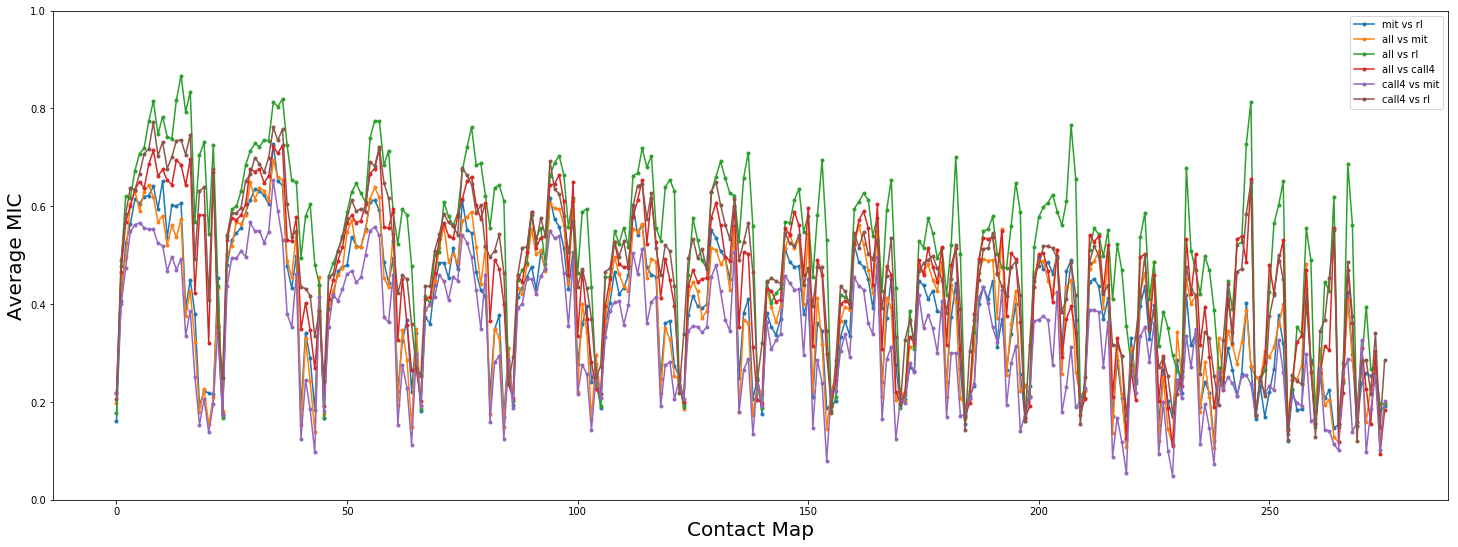

In [11]:
print(mics['mit']['rl'].shape)
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(len(mics['mit']['rl']))
ax = plt.subplot(1, 1, 1)
for cell1 in mics:
    for cell in mics[cell1]:
        if cell < cell1:
            continue
        y = np.nanmean(mics[cell1][cell][:,indices], axis=1)
        ax.plot(x, y, marker=".", label="%s vs %s"%(cell1, cell))
        ax.set_ylim([0, 1])
        ax.set_xlabel("Contact Map", fontsize=20)
        ax.set_ylabel("Average MIC", fontsize=20)
plt.legend()
plt.show()

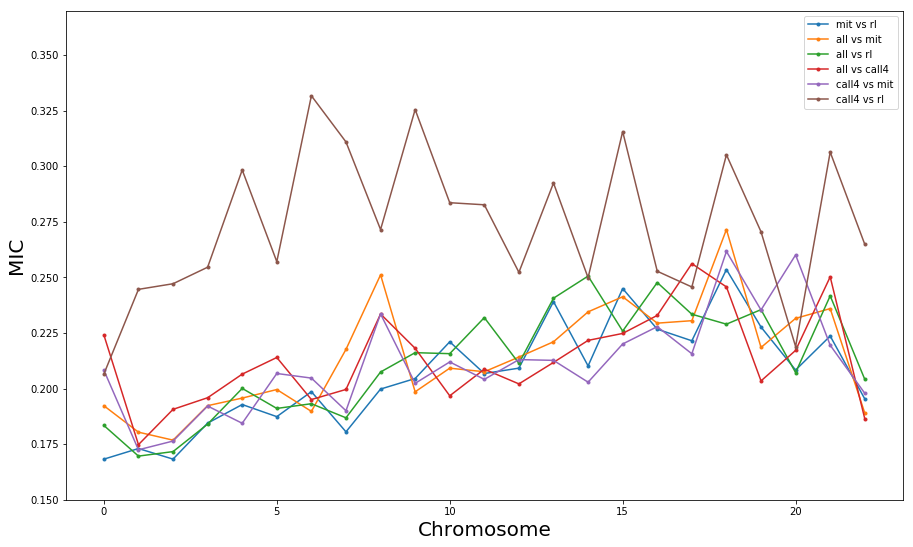

In [12]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(len(sameIndices))
ax = plt.subplot(1, 1, 1)
chosen_cell = 'all'
legends = []
for chosen_cell in mics:
    for cell in mics[chosen_cell]:
        if cell < chosen_cell:
            continue
        y = np.nanmean(mics[chosen_cell][cell][sameIndices,:], axis=1)
        tmp, = ax.plot(x, y, marker=".", label="%s vs %s"%(chosen_cell, cell))
        legends.append(tmp)
        ax.set(ylim=[0.15, .37])
        ax.set_xlabel('Chromosome', fontsize=20)
        ax.set_ylabel('MIC', fontsize=20)
plt.legend(handles=legends, loc=1)
plt.show()

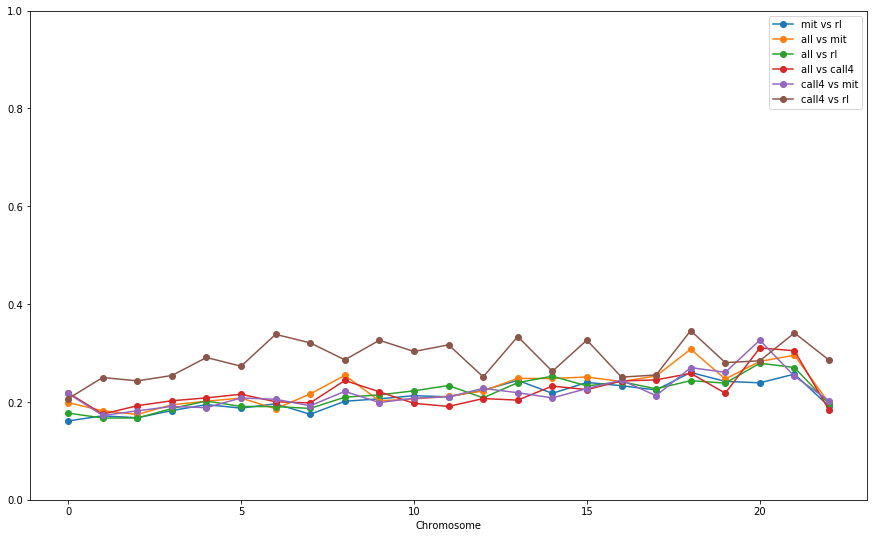

In [13]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(len(sameIndices))
ax = plt.subplot(1, 1, 1)
for cell1 in mics:
    for cell2 in mics[cell1]:
        if cell1 > cell2:
            continue
        y = np.nanmean(mics[cell1][cell2][sameIndices, :][:, indices], axis=1)
        ax.plot(x, y, marker="o", label="%s vs %s"%(cell1, cell2))
        ax.set(ylim=[0, 1], xlabel='Chromosome')
plt.legend()
plt.show()

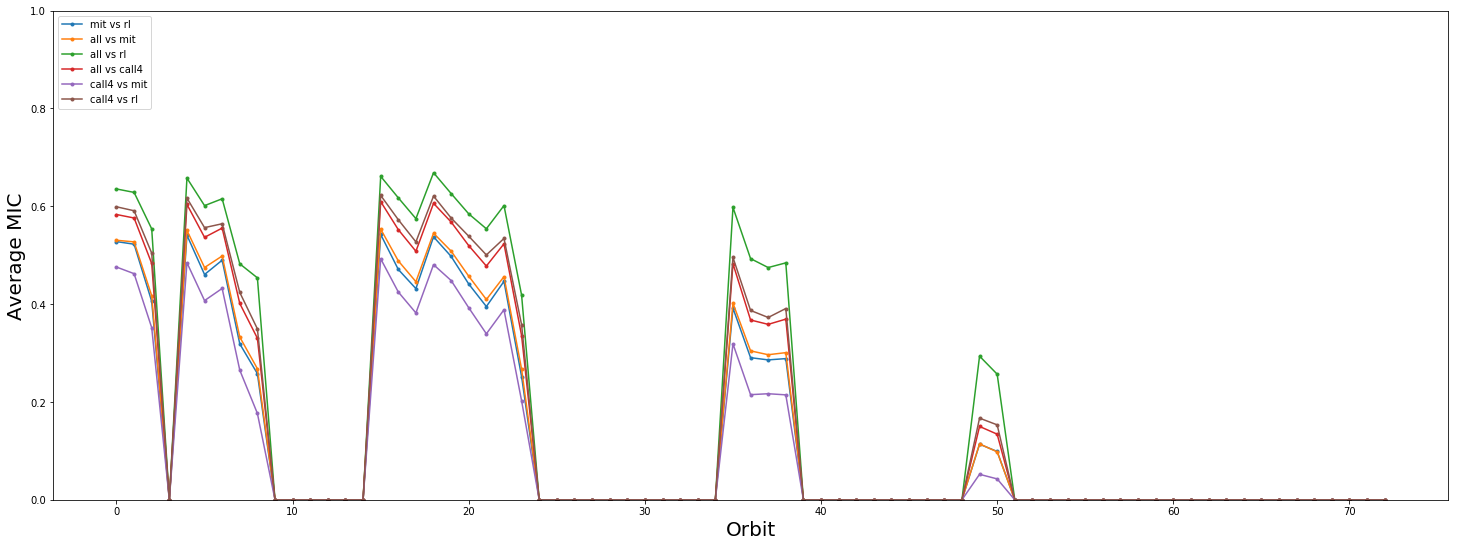

In [18]:
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(0, 73)
ax = plt.subplot(1, 1, 1)
legends = []
for cell1 in mics:
    for cell2 in mics[cell1]:
        if cell1 > cell2:
            continue
        y = np.mean(mics[cell1][cell2][differentIndices,:], axis=0)
        tmp, = ax.plot(x, y, marker=".", label="%s vs %s"%(cell1, cell2))
        legends.append(tmp)
        ax.set_ylim([0, 1])
        ax.set_ylabel("Average MIC", fontsize=20)
        ax.set_xlabel("Orbit", fontsize=20)
plt.legend(handles=legends, loc=2)
plt.show()

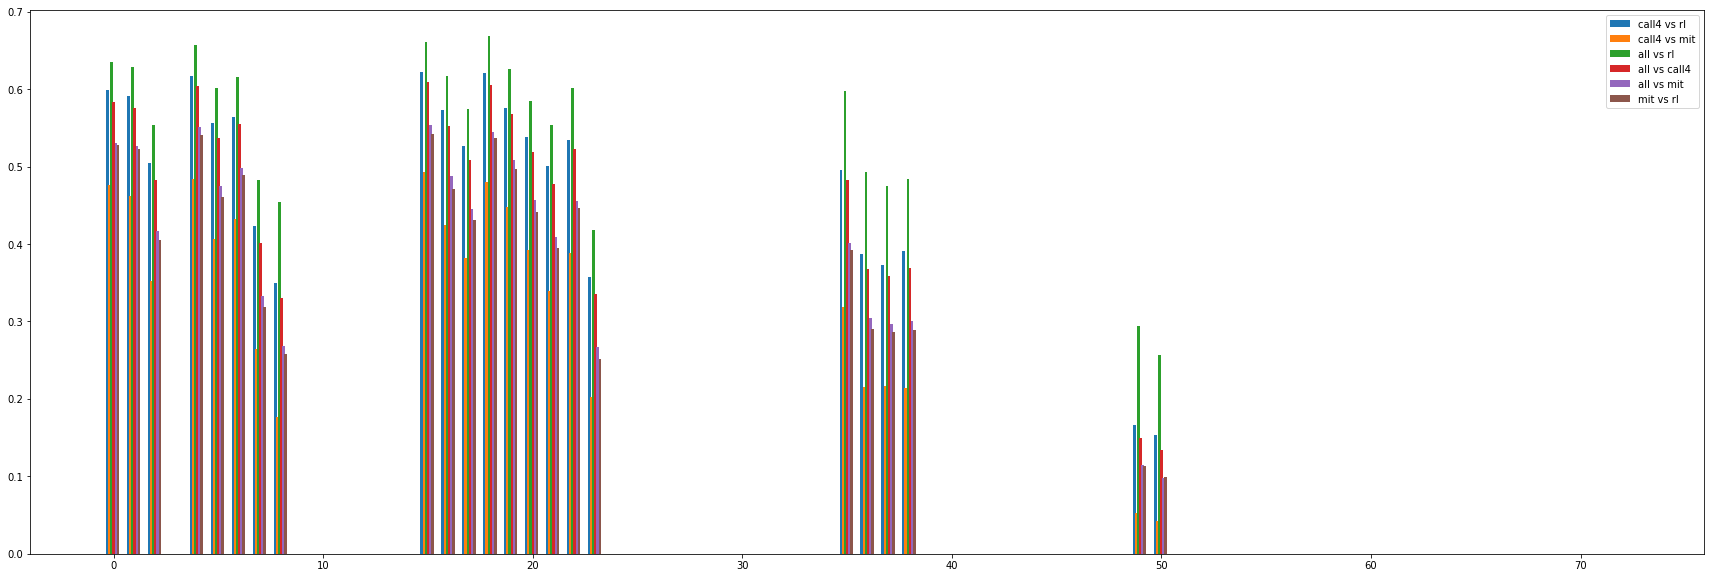

In [52]:
pylab.rcParams['figure.figsize'] = (30, 10)
x = np.array(range(0, 73))
ax = plt.subplot(1, 1, 1)
count = 0
displacement = np.array([-.3, -.2, -.1, 0, .1, .2])
for cell1 in mics:
    for cell2 in mics[cell1]:
        if cell1 > cell2:
            continue
        y = np.mean(mics[cell1][cell2][differentIndices,:], axis=0)
        ax.bar(x+displacement[count], y, width=.13, label="%s vs %s"%(cell1, cell2))
        count += 1
plt.legend()
plt.show()

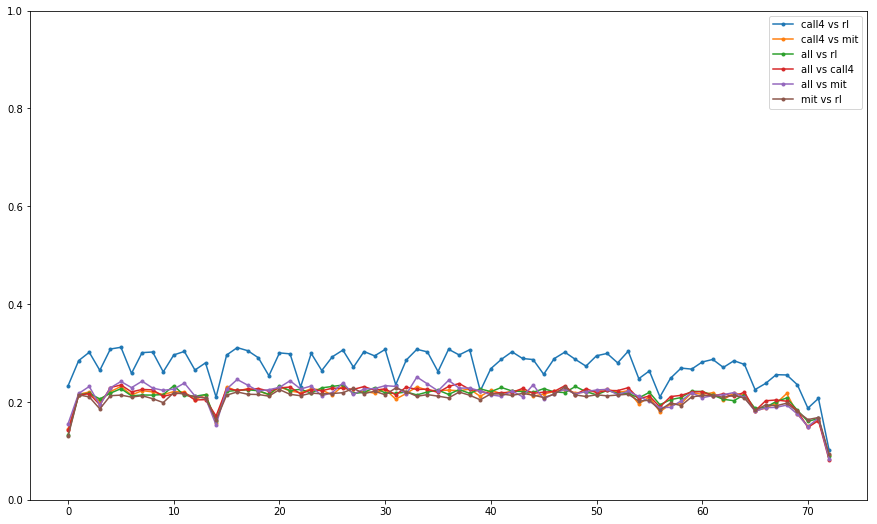

In [228]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(0, 73)
ax = plt.subplot(1, 1, 1)
for cell1 in mics:
    for cell2 in mics[cell1]:
        if cell1 > cell2:
            continue
        y = np.mean(mics[cell1][cell2][sameIndices,:], axis=0)
        ax.plot(x, y, marker=".", label="%s vs %s"%(cell1, cell2))
        ax.set_ylim([0, 1])
plt.legend()
plt.show()

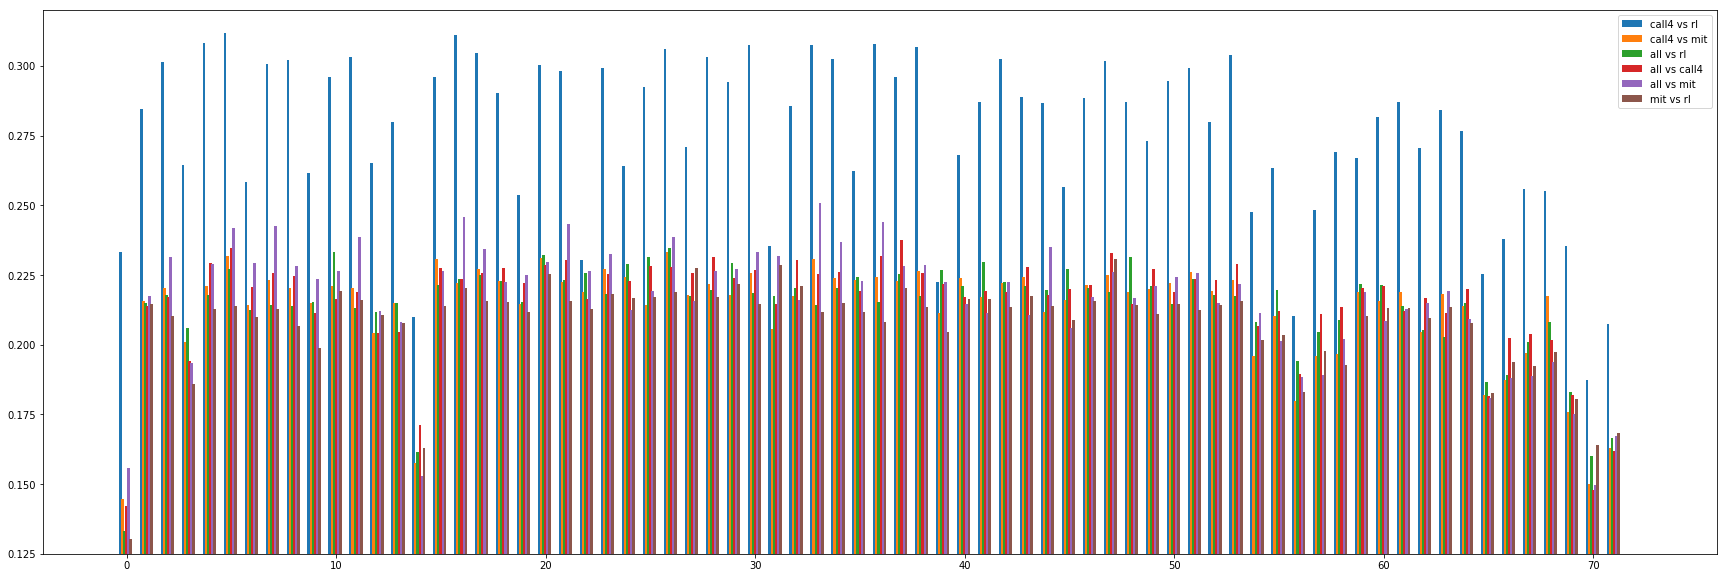

In [55]:
pylab.rcParams['figure.figsize'] = (30, 10)
x = np.array(range(0, 73))
ax = plt.subplot(1, 1, 1)
count = 0
displacement = np.array([-.3, -.2, -.1, 0, .1, .2])
for cell1 in mics:
    for cell2 in mics[cell1]:
        if cell1 > cell2:
            continue
        y = np.mean(mics[cell1][cell2][sameIndices,:], axis=0)
        ax.bar(x+displacement[count], y, width=.13, label="%s vs %s"%(cell1, cell2))
        count += 1
ax.set_ylim([.125, .32])
plt.legend()
plt.show()

## MIC statsitical analysis

### Comparison between contact maps

In [331]:
for chr1 in range(1, 24):
    for chr2 in range(chr1, 24):
        cmi = chr2count[(chr1, chr2)]
        a = []
        labels = []
        for cell1 in data_names:
            cell1 = cell1.lower()
            for cell2 in data_names:
                cell2 = cell2.lower()
                if cell2 <= cell1:
                    continue
                cm = mics[cell1][cell2][cmi]
                a.append(cm)
                labels.append("%s-%s"%(cell1, cell2))
        one_array = np.ones_like(cm)               
        a.append(one_array)
        labels.append("one")
        out, text = compare_pairwise(a, labels=labels)
        print("%2d %2d %s"%(chr1, chr2, text))

 1  1      mit-rl  <     all-rl  <    all-mit  <  call4-mit  =   call4-rl  <  all-call4  <        one
 1  2      mit-rl  =  call4-mit  <    all-mit  <     all-rl  =  all-call4  =   call4-rl  <        one
 1  3   call4-mit  <    all-mit  <     mit-rl  <  all-call4  <   call4-rl  <     all-rl  <        one
 1  4      mit-rl  =  call4-mit  <    all-mit  =     all-rl  =  all-call4  <   call4-rl  <        one
 1  5   call4-mit  <     mit-rl  <    all-mit  =  all-call4  =   call4-rl  <     all-rl  <        one
 1  6     all-mit  =  call4-mit  <     mit-rl  <  all-call4  <   call4-rl  <     all-rl  <        one
 1  7   call4-mit  <     mit-rl  =    all-mit  =  all-call4  <     all-rl  =   call4-rl  <        one
 1  8   call4-mit  <     mit-rl  <    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 1  9   call4-mit  <    all-mit  <     mit-rl  <  all-call4  <   call4-rl  <     all-rl  <        one
 1 10   call4-mit  <    all-mit  <     mit-rl  <  all-call4  <   call4-rl  <     a

 6 11   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 6 12   call4-mit  <    all-mit  <     mit-rl  =  all-call4  =   call4-rl  <     all-rl  <        one
 6 13   call4-mit  <    all-mit  =     mit-rl  =  all-call4  =   call4-rl  <     all-rl  <        one
 6 14   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <     all-rl  =   call4-rl  <        one
 6 15   call4-mit  <     mit-rl  =    all-mit  <  all-call4  =   call4-rl  <     all-rl  <        one
 6 16   call4-mit  <    all-mit  <     mit-rl  <  all-call4  <   call4-rl  <     all-rl  <        one
 6 17   call4-mit  <     mit-rl  <    all-mit  <  all-call4  =   call4-rl  <     all-rl  <        one
 6 18   call4-mit  <     mit-rl  <    all-mit  =  all-call4  =   call4-rl  <     all-rl  <        one
 6 19   call4-mit  <    all-mit  <     mit-rl  <  all-call4  <   call4-rl  <     all-rl  <        one
 6 20   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     a

utility.py:680: RuntimeWarning: divide by zero encountered in double_scalars
  t = avg / sd * np.sqrt(m*n)


12 20      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
12 21      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
12 22      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
12 23      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 13      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 14      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 15      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 16      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 17      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 18      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   cal

### Comparison between contact maps only considering non-zero orbits

In [332]:
for chr1 in range(1, 24):
    for chr2 in range(chr1, 24):
        cmi = chr2count[(chr1, chr2)]
        a = []
        labels = []
        for cell1 in data_names:
            cell1 = cell1.lower()
            for cell2 in data_names:
                cell2 = cell2.lower()
                if cell2 <= cell1:
                    continue
                cm = mics[cell1][cell2][cmi][indices]
                a.append(cm)
                labels.append("%s-%s"%(cell1, cell2))
        one_array = np.ones_like(cm)               
        a.append(one_array)
        labels.append("one")
        out, text = compare_pairwise(a, labels=labels)
        print("%2d %2d %s"%(chr1, chr2, text))

 1  1      mit-rl  <     all-rl  <    all-mit  =  all-call4  =  call4-mit  =   call4-rl  <        one
 1  2      mit-rl  =  call4-mit  <    all-mit  <     all-rl  =  all-call4  =   call4-rl  <        one
 1  3   call4-mit  <    all-mit  <     mit-rl  <  all-call4  <   call4-rl  <     all-rl  <        one
 1  4      mit-rl  =  call4-mit  <    all-mit  =     all-rl  =  all-call4  <   call4-rl  <        one
 1  5   call4-mit  <     mit-rl  <    all-mit  =  all-call4  =   call4-rl  <     all-rl  <        one
 1  6     all-mit  =  call4-mit  <     mit-rl  <  all-call4  <   call4-rl  <     all-rl  <        one
 1  7   call4-mit  <     mit-rl  =    all-mit  =  all-call4  <     all-rl  =   call4-rl  <        one
 1  8   call4-mit  <     mit-rl  <    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 1  9   call4-mit  <    all-mit  <     mit-rl  <  all-call4  <   call4-rl  <     all-rl  <        one
 1 10   call4-mit  <    all-mit  <     mit-rl  <  all-call4  <   call4-rl  <     a

 6  8      mit-rl  =  call4-mit  <    all-mit  <     all-rl  =  all-call4  =   call4-rl  <        one
 6  9   call4-mit  <     mit-rl  <    all-mit  <     all-rl  =  all-call4  =   call4-rl  <        one
 6 10      mit-rl  =  call4-mit  <    all-mit  =  all-call4  <     all-rl  =   call4-rl  <        one
 6 11   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 6 12   call4-mit  <    all-mit  <     mit-rl  =  all-call4  =   call4-rl  <     all-rl  <        one
 6 13   call4-mit  <    all-mit  =     mit-rl  =  all-call4  =   call4-rl  <     all-rl  <        one
 6 14   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <     all-rl  =   call4-rl  <        one
 6 15   call4-mit  <     mit-rl  =    all-mit  <  all-call4  =   call4-rl  <     all-rl  <        one
 6 16   call4-mit  <    all-mit  <     mit-rl  <  all-call4  <   call4-rl  <     all-rl  <        one
 6 17   call4-mit  <     mit-rl  <    all-mit  <  all-call4  =   call4-rl  <     a

12 22      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
12 23      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 13      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 14      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 15      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 16      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 17      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 18      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 19      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 20      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   cal

### Comparison between orbits

In [327]:
for o in range(73):
    a = []
    labels = []
    for cell1 in data_names:
        cell1 = cell1.lower()
        for cell2 in data_names:
            cell2 = cell2.lower()
            if cell2 <= cell1:
                continue
            cm = mics[cell1][cell2][:, o]
            a.append(cm)
            labels.append("%s-%s"%(cell1, cell2))
    one_array = np.ones_like(cm)               
    a.append(one_array)
    labels.append("one")
    out, text = compare_pairwise(a, labels=labels)
    print("%2d %s"%(o, text))

 0   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 1   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 2   call4-mit  <     mit-rl  <    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 3      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  <   call4-rl  <        one
 4   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 5   call4-mit  <     mit-rl  <    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 6   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 7   call4-mit  <     mit-rl  <    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 8   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 9      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  <   call4-rl  <        one
10      mi

### Comparison between orbits only for intra-chromosomal contact maps

In [325]:
for o in range(73):
    a = []
    labels = []
    for cell1 in data_names:
        cell1 = cell1.lower()
        for cell2 in data_names:
            cell2 = cell2.lower()
            if cell2 <= cell1:
                continue
            cm = mics[cell1][cell2][sameIndices, o]
            a.append(cm)
            labels.append("%s-%s"%(cell1, cell2))
    one_array = np.ones_like(cm)               
    a.append(one_array)
    labels.append("one")
    out, text = compare_pairwise(a, labels=labels)
    print("%2d %s"%(o, text))

 0      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  <   call4-rl  <        one
 1      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  <   call4-rl  <        one
 2      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  <   call4-rl  <        one
 3      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  <   call4-rl  <        one
 4      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  <   call4-rl  <        one
 5      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  <   call4-rl  <        one
 6      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
 7      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  <   call4-rl  <        one
 8      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  <   call4-rl  <        one
 9      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  <   call4-rl  <        one
10      mi

### Comparison between orbits only for non-zero orbits

In [328]:
for o in indices:
    a = []
    labels = []
    for cell1 in data_names:
        cell1 = cell1.lower()
        for cell2 in data_names:
            cell2 = cell2.lower()
            if cell2 <= cell1:
                continue
            cm = mics[cell1][cell2][:, o]
            a.append(cm)
            labels.append("%s-%s"%(cell1, cell2))
    one_array = np.ones_like(cm)               
    a.append(one_array)
    labels.append("one")
    out, text = compare_pairwise(a, labels=labels)
    print("%2d %s"%(o, text))

 0   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 1   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 2   call4-mit  <     mit-rl  <    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 4   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 5   call4-mit  <     mit-rl  <    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 6   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 7   call4-mit  <     mit-rl  <    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 8   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
15   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
16   call4-mit  <     mit-rl  <    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
17   call4